<h1 align="center">PERFORMANCE EVALUATION</h1>
<h3><mark style="background-color: yellow">CONTENTS</mark></h3>

- [**MODEL EVALUATION**](#intro)
    - [**Problem With Naive Data Preparation**](#problem)
    - [**Data Preparation Without Data Leakage**](#leak)
- [**RESAMPLING TECHNIQUES FOR EVALUATING PERFORMANCE**](#resample)
    - [**Resampling With Train and Test Sets**](#train)
    - [**Resampling With k-fold Cross-Validation**](#kfold)
    - [**Resampling With Repeated Random Test-Train Splits**](#repeat)
    - [**How to Choose a Resampling Method**](#resamp)
- [**BASELINE MODELS**](#base)
    - [**Creating a Baseline Regression Model**](#reg)
    - [**Creating a Baseline Classification Model**](#clas)
    - [**Simple Example**](#eg)
- [**MACHINE LEARNING ALGORITHM PERFORMANCE METRICS**](#metrics)
    - [**Binary Classification Metrics**](#class)
        - [**Accuracy**](#acc)
        - [**Precision**](#pre)
        - [**Recall**](#rec)
        - [**F1**](#f1)
        - [**Examples with `cross_val_score` and `cross_validate`**](#cross)
        - [**Visualize Precision-Recall Curves For Binary Classification**](#prc)
        - [**Logarithmic Loss**](#log)
        - [**Area Under ROC Curve**](#roc)
        - [**Discrimination Threshold**](#disc)
    - [**Multiclass Classification Metrics**](#multi)
        - [**Visualize Precision-Recall Curves For Multi-Class Classification**](#prmc)
        - [**Multi-class ROCAUC Curves**](#mcroc)
        - [**Confusion Matrix**](#matrix)
        - [**Classification Report**](#report)
    - [**Regression Metrics**](#reg)
        - [**Mean Absolute Error**](#mae)
        - [**Mean Squared Error**](#mse)
        - [**Root Mean Squared Error**](#rmse)
        - [**R-squared $R^2$**](#squared)
    - [**Clustering Metrics**](#clust)
        - [**Silhouette Score**](#sil)
    - [**Creating Custom Metrics**](#create)
    - [**Visualizing the Effect of Training Set Size (Learning Curve)**](#lcurve)
    - [**Visualizing the Effect of Hyperparameter
Values (Validation curve)**](#vcurve)
- [**SPOT-CHECK MACHINE LEARNING ALGORITHMS**](#ml)
    - [**Classification Models**](#spot)
    - [**Regression Models**](#check)
- [**AUTOMATE MACHINE LEARNING WORKFLOWS WITH PIPELINES**](#auto)
    - [**Data Preparation and Modeling Pipeline**](#pipe)
    - [**Feature Extraction and Modeling Pipeline**](#extract)
- [**IMPROVE PERFORMANCE WITH ENSEMBLES**](#ensemble)
    - [**Bagging Algorithms**](#bag)
        - [**Bagged Decision Trees**](#bagtree)
        - [**Random Forest**](#forest)
        - [**Extra Trees**](#extra)
    - [**Boosting Algorithms**](#boost)
        - [**AdaBoost**](#ada)
        - [**Stochastic Gradient Boosting**](#gradient)
    - [**Voting Ensemble**](#vote)
- [**IMPROVE PERFORMANCE WITH ALGORITHM TUNING**](#tune)
   - [**Exhaustive Search: Grid Search Parameter Tuning**](#grid)
   - [**Random Search Parameter Tuning**](#random)
   - [**Selecting Best Models from Multiple Learning Algorithms**](#best)
- [**SAVE AND LOAD MACHINE LEARNING MODELS**](#save)
    - [**Finalize Your Model with pickle**](#pickle)
    - [**Finalize Your Model with Joblib**](#joblib)
- [**REFERENCES**](#ref)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.linear_model import (LinearRegression, LogisticRegression,
                                  RidgeClassifier)

from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report)

from sklearn.model_selection import (train_test_split, cross_val_score, KFold,
                                     StratifiedKFold, RepeatedStratifiedKFold, 
                                     GroupKFold, LeaveOneOut, ShuffleSplit)

In [3]:
from sklearn.ensemble import RandomForestClassifier

<a id="intro"></a>
<h2 align="center" style="text-decoration:underline">MODEL EVALUATION</h2>

The goal of predictive modeling is to create models that make good predictions on new data. Thus, it is important to know how well these machine learning algorithms perform on unseen data. The best way to evaluate the performance of an algorithm would be to make predictions for new data to which we already know the answers. The second best way is to use clever techniques from statistics called **resampling methods**, as they are resampling the available training data. The goal of resampling methods is to make the best use of the training data in order to accurately estimate the performance of a model on new unseen data. Accurate estimates of performance can then be used to help choose which set of model parameters to use or which model to select. Once we estimate the performance of our algorithm, we can then re-train the final algorithm on the entire training dataset and get it ready for operational use.

So why can’t we train a machine learning algorithm on the dataset and use predictions from this same dataset to evaluate machine learning algorithms? The simple answer is **overfitting**. Imagine an algorithm that remembers every observation it is shown during training. If we evaluated a machine learning algorithm on the same dataset used to train the algorithm, then an algorithm like this would have a perfect score on the training dataset. But the predictions it made on new data would be terrible.<br>
$\;\;\;\;\;\;\;$We must evaluate the machine learning algorithms on data that is not used to train the algorithm. This evaluation is an estimate that we can use to talk about how well we think the algorithm may actually do in practice. However, it is not a guarantee of performance. 

<a id="problem"></a>
<h3 style="text-decoration:underline">Problem With Naive Data Preparation</h3>

Data preparation is the process of transforming raw data into a form that is appropriate for modeling. The manner in which data preparation techniques are applied to data significantly matters.<br>
$\;\;\;\;\;\;\;$A naive approach to preparing data is to first apply any transforms to the entire dataset. The transformed dataset is then either split into train and test sets or k-fold cross-validation is used to fit and evaluate a machine learning model.<br>
$\;\;\;\;\;\;\;$Although this is a common approach, it is dangerously incorrect in most cases. The problem with applying data preparation techniques before splitting data for model evaluation is that it can lead to **data leakage** and, in turn, will *likely result in an incorrect estimate of a model’s performance on the problem.* Data leakage refers to a problem where knowledge/information about the holdout dataset, such as a test or validation dataset, is made available to (or leaks into) the model in the training phase. *This leakage is often small and subtle but can have a marked effect on performance.*
>A careful application of data preparation techniques is required in order to avoid data leakage, and this varies depending on the model evaluation scheme used, such as **train test splits** or **k-fold cross-validation**.

<a id="leak"></a>
<h3 style="text-decoration:underline">Data Preparation Without Data Leakage</h3>

We get data leakage by applying data preparation techniques to the entire dataset. This is not a direct type of data leakage, where we would train the model on the test dataset. Instead, it is an indirect type of data leakage, where some knowledge about the test dataset, captured in summary statistics is available to the model during training. This can make it a harder type of data leakage to spot, especially for beginners. For example:
- Consider the case where we want to normalize data, that is scale input variables to the range 0-1. This requires that we first calculate the minimum and maximum values for each variable before using these values to scale the variables. The dataset is then split into train and test datasets. But, the examples in the training dataset know something about the data in the test dataset; they have been scaled by the global minimum and maximum values, so they know more about the global distribution of the variable then they should.
- We get the same type of leakage with almost all data preparation techniques; for example, standardization estimates the mean and standard deviation values from the domain in order to scale the variables.
- Even models that impute missing values using a model or summary statistics will draw on the full dataset to fill in values in the training dataset. 

**The solution is straightforward.** Data preparation must be fit on the training dataset only. That is, any coefficients or models prepared for the data preparation process must only use rows of data in the training dataset. Once fit, the data preparation algorithms or models can then be applied to the training dataset, and to the test dataset.

1. Split Data.
2. Fit Data Preparation on Training Dataset.
3. Apply Data Preparation to Train and Test Datasets.
4. Evaluate Models.

>**More generally, the entire modeling pipeline must be prepared only on the training dataset to avoid data leakage. This might include data transforms, but also other techniques such as feature selection, dimensionality reduction, feature engineering and more.**

<a id="resample"></a>
<h2 align="Center" style="text-decoration:underline">RESAMPLING TECHNIQUES FOR EVALUATING PERFORMANCE</h2>

At first consideration, evaluating supervised-learning models might appear straightforward: train a model and then calculate how well it did using some performance metric (accuracy, squared errors, etc.). However, *this approach is fundamentally flawed*. If we train a model using our data, and then evaluate how well it did on that data, we are not achieving our desired goal. Our goal is not to evaluate how well the model does on our training data, but how well it does on data it has never seen before. For this reason, our method of evaluation should help us understand how well models are able to make predictions from data they have never seen before.

One strategy might be to hold off a slice of data for testing. This is called **validation (or hold-out)**. In validation our observations (features and targets) are split into two sets, traditionally called the **training and test sets**. We take the test set and put it off to the side, pretending that we have never seen it before. Next we train a model using the training set, using the features and target vector to teach the model how to make the best prediction. Finally, we simulate having never before seen external data by evaluating how the model trained on the training set performs on the test set. However, the validation approach has two major weaknesses. First, the performance of the model can be highly dependent on which few observations were selected for the test set. Second, the model is not being trained using all the available data, and not being evaluated on all the available data.

A better strategy, which overcomes these weaknesses, is called **k-fold cross-validation (KFCV)**. In KFCV, we split the data into $k$ parts called "folds". The model is then trained using $k–1$ folds — combined into one training set — and then the last fold is used as a test set. We repeat this $k$ times, each time using a different fold as the test set. The performance on the model for each of the $k$ iterations is then averaged to produce an overall measurement.

<a id="train"></a>
<h3 style="text-decoration:underline">Resampling With Train and Test Sets</h3>

The **train and test split** is the easiest resampling method we can use to evaluate the performance of a machine learning algorithm. As such, it is the most widely used. The correct approach to performing data preparation with a train-test split evaluation is to first split the data, fit the data preparation on the training set, then apply the transform to the train and test sets.<br>
$\;\;\;\;\;\;\;$This algorithm evaluation technique is very fast and ideal for large datasets (millions of records) where there is strong evidence that both splits of the data are representative of the underlying problem. Because of the speed, it is useful to use this approach when the algorithm under investigaton is slow to train. A downside of this technique is that it can have a high variance. This means that differences in the training and test dataset can result in meaningful differences in the estimate of accuracy.

If multiple algorithms are compared or multiple configurations of the same algorithm are compared, the same train and test split of the dataset should be used. This is to ensure that the comparison of performance is consistent or apples-to-apples. We can achieve this by seeding the random number generator the same way before splitting the data, or by holding the same split of the dataset for use by multiple algorithms.

In [4]:
from sklearn.datasets import make_classification

# define dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=15, n_redundant=5, random_state=7)

In [5]:
# Naive Approach - scale then split

# prepare and transform the data beofre splitting
scaler_incorrect = MinMaxScaler()
X_nay = scaler_incorrect.fit_transform(X)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_nay, y, test_size=0.33,
                                                    random_state=1)
# fit the model
model = LogisticRegression()
model.fit(X_train,y_train)

# evaluate the model
yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy with the Naive Approach: {accuracy*100:.4f}')

Accuracy with the Naive Approach: 84.8485


In [6]:
# Correct Approach - split then scale

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=1)
# prepare and transform the data
scaler_correct = MinMaxScaler()
scaler_correct.fit(X_train)
X_train_cor = scaler_correct.transform(X_train)
X_test_cor = scaler_correct.transform(X_test)

# fit the model
model = LogisticRegression()
model.fit(X_train_cor, y_train)

# evaluate the model
yhat = model.predict(X_test_cor)
accuracy = accuracy_score(y_test, yhat)
print(f'Accuracy with the Correct Approach: {accuracy*100:.4f}')

Accuracy with the Correct Approach: 85.4545


In [7]:
# Correct Approach - using Pipelines

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=1)

pipe = Pipeline(steps=[('std', MinMaxScaler()),
                       ('log', LogisticRegression())])
pipe.fit(X_train,y_train)
preds = pipe.predict(X_test)
ccuracy = accuracy_score(y_test, preds)
print(f'Accuracy with Pipeline Approach: {accuracy*100:.4f}')

Accuracy with Pipeline Approach: 85.4545


<a id="kfold"></a>
<h3 style="text-decoration:underline">Resampling With k-fold Cross-Validation</h3>

A limitation of using the train and test split method is that you get a noisy estimate of algorithm performance. The **k-fold cross-validation** resampling procedure generally gives a more accurate and reliable estimate of model performance with less variance than a single train-test split, although it is more computationally expensive given the repeated fitting and evaluation of models.

k-fold cross-validation involves splitting the dataset into $k$ non-overlapping groups of rows. The algorithm is then trained on all but one group to form a training dataset and then evaluated on the held-out fold. This process is repeated $k$ times so that each fold is given a chance to be used as the holdout test set. Finally, the average performance across all evaluations is reported. <br>
$\;\;\;\;\;\;\;$Data preparation without data leakage when using cross-validation is slightly more challenging. It requires that the data preparation method is prepared on the training set and applied to the train and test sets within the cross-validation procedure, e.g. the groups of folds of rows. We can achieve this by defining a modeling **pipeline** that defines a sequence of data preparation steps to perform and ending in the model to fit and evaluate.

>**The choice of $k$ must allow the size of each test partition to be large enough to be a reasonable sample of the problem, whilst allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on unseen data. A good default to use is $k=3$ for a small dataset or $k=10$ for a larger dataset. A quick way to check if the fold sizes are representative is to calculate summary statistics such as mean and standard deviation and see how much the values differ from the same statistics on the whole dataset.**

There are three important points to consider when using k-fold crossvalidation (KFCV). First, KFCV assumes that each observation was created independent from the other (i.e., the data is independent identically distributed [IID]). If the data is IID, it is a good idea to shuffle observations when assigning to folds. In scikit-learn, set `shuffle=True` to perform shuffling.<br>
$\;\;\;\;\;\;$Second, when using KFCV to evaluate a classifier, it is often beneficial to have folds containing roughly the same percentage of observations from each of the different target classes (called stratified k-fold). For example, if our target vector contained gender and 80% of the observations were male, then each fold would contain 80% male and 20% female observations. In scikit-learn, we can conduct stratified k-fold cross-validation by replacing the **KFold** class with **StratifiedKFold**.<br>
$\;\;\;\;\;\;$Finally, when using validation sets or cross-validation, it is important to preprocess data based on the training set and then apply those transformations to both the training and test set. The reason for this is because we are pretending that the test set is unknown data. If we fit both our preprocessors using observations from both training and test sets, some of the information from the test set leaks into our training set. This rule applies for any preprocessing step such as feature selection. To avoid data leakage with KFCV, we can use scikit-learn’s **Pipeline** class.

[Check the docs for more info](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)

In [8]:
# correct data preparation for model evaluation with k-fold cross-validation

# define the pipeline
steps = [('scaler', MinMaxScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = KFold(n_splits=10, shuffle=False, random_state=None)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using KFold with MinMaxScaler and shuffle=False')
print('-'*56)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using KFold with MinMaxScaler and shuffle=False
--------------------------------------------------------
84.900 +/-(1.814)


In [9]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = KFold(n_splits=10, shuffle=False, random_state=None)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using KFold with StandardScaler and shuffle=False')
print('-'*58)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using KFold with StandardScaler and shuffle=False
----------------------------------------------------------
87.000 +/-(2.449)


Here we are using `cross-validate` instead of `cross_val_score`. 

In [10]:
from sklearn.model_selection import cross_validate

In [11]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = KFold(n_splits=10, shuffle=False, random_state=None)

# evaluate the model using cross-validation
scores = cross_validate(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# scores.keys()
mean = np.mean(scores['test_score'])*100
std = np.std(scores['test_score'])*100

# report performance
print('Accuracy using cross-validate')
print('-'*58)
print(f'{mean:.3f} +/-({std:.3f})')

Accuracy using cross-validate
----------------------------------------------------------
87.000 +/-(2.449)


A benefit of `cross-validate` is the ability to use multiple scorers.

In [12]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = KFold(n_splits=10, shuffle=False, random_state=None)

# evaluate the model using cross-validation
scores = cross_validate(pipeline, X, y, scoring=['accuracy','precision'],
                        cv=cv, n_jobs=-1)
print(scores.keys())
print(f"accuracy: {scores['test_accuracy']}")
print(f"precision: {scores['test_precision']}")

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision'])
accuracy: [0.84 0.87 0.84 0.9  0.85 0.92 0.88 0.86 0.86 0.88]
precision: [0.84745763 0.89130435 0.91111111 0.85714286 0.85454545 0.92307692
 0.84210526 0.8627451  0.88235294 0.84313725]


In [13]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using KFold with StandardScaler and shuffle=True')
print('-'*57)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using KFold with StandardScaler and shuffle=True
---------------------------------------------------------
86.200 +/-(1.400)


In [14]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using StratifiedKFold with StandardScaler and shuffle=False')
print('-'*68)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using StratifiedKFold with StandardScaler and shuffle=False
--------------------------------------------------------------------
87.100 +/-(2.256)


In [15]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using StratifiedKFold with StandardScaler and shuffle=True')
print('-'*68)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using StratifiedKFold with StandardScaler and shuffle=True
--------------------------------------------------------------------
86.600 +/-(2.871)


In [16]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using RepeatedStratifiedKFold with StandardScaler')
print('-'*58)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using RepeatedStratifiedKFold with StandardScaler
----------------------------------------------------------
86.370 +/-(3.196)


We can configure cross validation so that the size of the fold is 1 (k is set to the number of observations in the dataset). This variation of cross validation is called **leave-one-out cross-validation**. The result is a large number of performance measures that can be summarized in an effort to give a more reasonable estimate of the accuracy of the model on unseen data. A downside is that it can be a computationally more expensive procedure than k-fold cross validation. 

In [17]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = LeaveOneOut()

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using LeaveOneOut with StandardScaler')
print('-'*58)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using LeaveOneOut with StandardScaler
----------------------------------------------------------
86.500 +/-(34.172)


The scores for Leave-One-Out cross-validation has significantly more variance than the previous k-fold cross-validation results.

<a id="repeat"></a>
<h3 style="text-decoration:underline">Resampling With Repeated Random Test-Train Splits</h3>

Another variation on k-fold cross validation is to create a random split of the data like the train/test split described above, but repeat the process of splitting and evaluation of the algorithm multiple times, like cross validation. This has the speed of using a train/test split and the reduction in variance in the estimated performance of k-fold cross validation. You can also repeat the process many more times as needed to improve the accuracy. A down side is that repetitions may include much of the same data in the train or the test split from run to run, introducing redundancy into the evaluation.

In [18]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy using ShuffleSplit with StandardScaler')
print('-'*58)
print(f'{np.mean(scores)*100:.3f} +/-({np.std(scores)*100:.3f})')

Accuracy using ShuffleSplit with StandardScaler
----------------------------------------------------------
86.200 +/-(1.802)


<a id="resamp"></a>
<h3 style="text-decoration:underline">How to Choose a Resampling Method</h3>

The gold standard for estimating the performance of machine learning algorithms on new data is k-fold cross-validation. When well-configured, k-fold cross-validation gives a robust estimate of performance compared to other methods such as the train and test split. The downside of cross-validation is that it can be time-consuming to run, requiring $k$ different models to be trained and evaluated. This is a problem if you have a very large dataset or if you are evaluating a model that takes a long time to train.

The train and test split resampling method is the most widely used. This is because it is easy to understand and implement, and because it gives a quick estimate of algorithm performance. Only a single model is constructed and evaluated. Although the train and test split method can give a noisy or unreliable estimate of the performance of a model on new data, this becomes less of a problem if you have a very large dataset. Using a train/test split is good for speed when using a slow algorithm and produces performance estimates with lower bias when using large datasets.

Large datasets are those in the hundreds of thousands or millions of records, large enough that splitting it in half results in two datasets that have nearly equivalent statistical properties. In such cases, there may be little need to use k-fold cross-validation as an evaluation of the algorithm and a train and test split may be just as reliable.

Techniques like leave-one-out cross validation and repeated random splits can be useful intermediates when trying to balance variance in the estimated performance, model training speed and dataset size.

<a id="base"></a>
<h2 align="center" style="text-decoration:underline">BASELINE MODELS</h2>

With hundreds of machine learning algorithms to choose from. How do you know whether the predictions for a given algorithm are good or not? The answer is to use a **baseline prediction algorithm**.

When doing supervised learning, a simple sanity check consists of comparing one’s estimator against simple rules of thumb that can be used as a baseline model to provide a point of comparison for the more advanced algorithms.

A baseline model uses heuristics, simple summary statistics, randomness, or machine learning to create predictions from a dataset. These predictions can be evaluated using metrics such as classification accuracy or RMSE. The scores from these baseline algorithms provide the required point of comparison when evaluating all other machine learning algorithms. Once established, we can comment on how much better a given algorithm is compared to the naive baseline algorithm, providing context on just how good a given method actually is.

The two commonly used baseline methods are:
- **Random Prediction Algorithm** - predicts a random (distinct) outcome.
- **Zero Rule Algorithm** - uses more information about a given problem to create one rule in order to make predictions. This rule is different depending on the problem type. 
    - For **classification** problems, the one rule is to predict the class value that is most common in the training dataset. 
    - **Regression** problems require the prediction of a real value. A good default prediction for real values is to predict the central tendency. This could be the mean or the median. This is likely to have a lower error than random prediction which will return any observed output value.

When starting on a new problem that is more difficult than a conventional classification or regression problem, it is a good idea to first devise a random prediction algorithm that is specific to the prediction problem. Later you can improve upon this and devise a zero rule algorithm.

Besides using the mean or the value counts as a baseline model, we can also use [scikit learn](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators) to perform this for both classification and regression problems. 
>**Note that with all these strategies, the predict method completely ignores the input data**

In [19]:
from sklearn.dummy import DummyRegressor

<a id="reg"></a>
<h3 style="text-decoration:underline">Creating a Baseline Regression Model</h3>

```python
DummyRegressor(strategy='mean', constant=None, quantile=None)
```
This regressor makes predictions using simple rules and is useful as a simple baseline to compare with other (real) regressors. 
- `strategy` : {"mean", "median", "quantile", "constant"}, default="mean"
- `constant` : int or float , default=None
- `quantile` : float in [0.0, 1.0], default=None<br>A quantile of 0.5 corresponds to the median, while 0.0 to the min and 1.0 to the max.


In [20]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
         'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT', 'MEDV']

df_hous = pd.read_csv("./datasets/Evaluation Metrics/boston_housing.csv",
                 names=names)

X_hous = df_hous.drop(columns=['MEDV'])
Y_hous = df_hous['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X_hous, Y_hous,
                                                    test_size=0.3,
                                                    random_state=1)
df_hous.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [21]:
# Create a dummy regressor
dummy = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy.fit(X_train, y_train)

# Get R-squared score
dummy.score(X_test, y_test)

# # define the pipeline
# steps = [('model', DummyRegressor(strategy='mean'))]
# pipe = Pipeline(steps=steps)
# pipe.fit(X_train, y_train)
# pipe.score(X_test, y_test)

-0.0045026262274585616

In [22]:
# Create a dummy regressor
dummy = DummyRegressor(strategy='constant', constant=20)

# "Train" dummy regressor
dummy.fit(X_train, y_train)

# Get R-squared score
dummy.score(X_test, y_test)

-0.09703547380644584

In [23]:
# Create a dummy regressor
dummy = DummyRegressor(strategy='quantile', quantile=0.2)
# DummyRegressor(strategy='median')

# "Train" dummy regressor
dummy.fit(X_train, y_train)

# Get R-squared score
dummy.score(X_test, y_test)

-0.6075532191438029

To compare, we train a linear regression model and evaluate the performance score:

In [24]:
# define the pipeline
steps = [('scaler', StandardScaler()), ('model', LinearRegression())]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7836295385076293

**DummyRegressor** allows us to create a very simple model that we can use as a baseline to compare against an actual model. This can often be useful to simulate a "naive" existing prediction process in a product or system. 

<a id="clas"></a>
<h3 style="text-decoration:underline">Creating a Baseline Classification Model</h3>

A major motivation of this method is F1-scoring, when the positive class is a minority.

```python
DummyClassifier(strategy='prior', random_state=None, constant=None)
```    
This is a classifier that makes predictions using simple rules. This classifier is useful as a simple baseline to compare with other (real) classifiers. 

- `strategy` : default="prior"
    - **"stratified"**: generates predictions by respecting the training
      set's class distribution.
    - **"most_frequent"**: always predicts the most frequent label in the
      training set.
    - **"prior"**: always predicts the class that maximizes the class prior
      (like "most_frequent") and ``predict_proba`` returns the class prior.
    - **"uniform"**: generates predictions uniformly at random.
    - **"constant"**: always predicts a constant label that is provided by
      the user. This is useful for metrics that evaluate a non-majority
      class.
- `random_state` : int, RandomState instance or None, default=None<br>
    Controls the randomness to generate the predictions when ``strategy='stratified'`` or ``strategy='uniform'``.
- `constant` : int or str<br>
    The explicit constant as predicted by the "constant" strategy. This
    parameter is useful only for the "constant" strategy.

In [25]:
from sklearn.dummy import DummyClassifier

In [26]:
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass',
         'pedi', 'age', 'target']
df_diab = pd.read_csv("./datasets/Evaluation Metrics/Diabetes.csv", names=names)

X_diab = df_diab.drop(columns=['target'])
Y_diab = df_diab['target']

X_train, X_test, y_train, y_test = train_test_split(X_diab, Y_diab,
                                                    test_size=0.3,
                                                    random_state=1)
df_diab.head(2)

,preg,plas,pres,skin,test,mass,pedi,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [27]:
# Create a dummy regressor
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" dummy regressor
dummy.fit(X_train, y_train)

# Get R-squared score
dummy.score(X_test, y_test)

0.48484848484848486

In [28]:
# define the pipeline
steps = [('scaler', StandardScaler()), 
         ('model',  RandomForestClassifier())]
pipe = Pipeline(steps=steps)
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7965367965367965

A common measure of a classifier’s performance is how much better it is than random guessing. scikit-learn’s **DummyClassifier** makes this comparison easy. The strategy parameter gives us a number of options for generating values. There are two particularly useful strategies. First, `stratified` makes predictions that are proportional to the training set’s target vector’s class proportions (i.e., if 20% of the observations in the training data are women, then DummyClassifier will predict women 20% of the time). Second, `uniform` will generate predictions uniformly at random between the different classes. For example, if 20% of observations are women and 80% are men, uniform will produce predictions that are 50% women and 50% men.

<a id="eg"></a>
<h3 style="text-decoration:underline">Simple Example</h3>

In [29]:
# time spent in sport (hrs)
x = np.array([2,4,8,6,1,4,3,6,0,1])

# scores in a test
y = np.array([41, 59,  7, 24, 74, 28, 40, 29, 78, 55])

# Method 1 - converting data into a dictionary
# d = {'Play_sport(hrs)':x,'Test_scores':y}
# df = pd.DataFrame(data=d)

# Method 2 - joining 2 dataframes
# df1 = pd.DataFrame(x, columns=['Play_sport(hrs)'])
# df2 = pd.DataFrame(y, columns=['Test_scores'])
# df = df1.join(df2)

# Method 3 - this method only works if we transpose the data first
# df = pd.DataFrame(data=[x,y]).T
# df.columns = ['Play_sport(hrs)','Test_scores']

# Method 4 - applying numpy's horizontal stack method
# df = pd.DataFrame(data=np.hstack((x[:,None],y[:,None])),
#                   columns = ['Play_sport(hrs)','Test_scores'])

# Method 5 - starting with an empty dataframe
df = pd.DataFrame()
df['Play_sport(hrs)'] = x
df['Test_scores'] = y

df.head(2)

,Play_sport(hrs),Test_scores
0,2,41
1,4,59


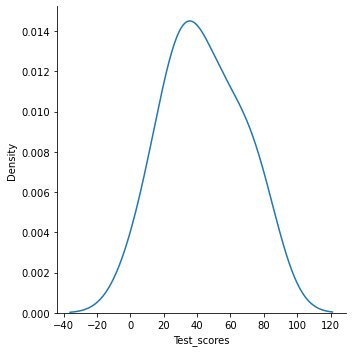

In [30]:
# distribution plot of the test scores (the blue bars and blue line)
sns.displot(df['Test_scores'], label='distribution', kind='kde')

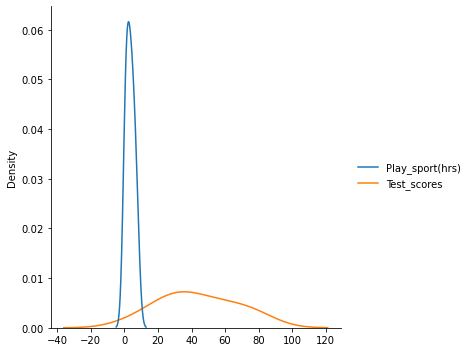

In [31]:
sns.displot(df, kind='kde')

[(-40.0, 120.0)]

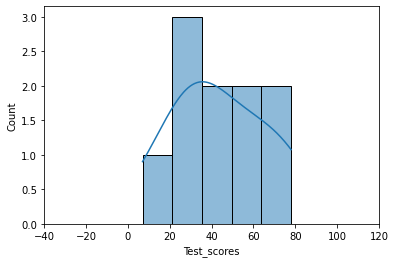

In [32]:
plot = sns.histplot(df['Test_scores'], label='distribution', kde=True)
plot.set(xlim=(-40, 120))

C:\Users\Michael\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Test_scores', ylabel='Density'>

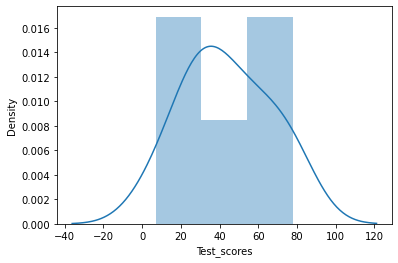

In [33]:
# distribution plot of the test scores (the blue bars and blue line)
sns.distplot(df['Test_scores'], label='distribution')

C:\Users\Michael\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


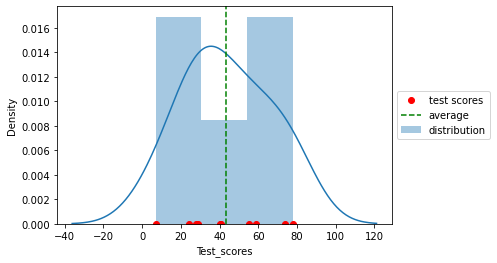

In [34]:
# distribution plot of the test scores (the blue bars and blue line)
sns.distplot(df['Test_scores'], label='distribution')

# plotting the test scores along the x-axis (the red dots)
plt.plot(df['Test_scores'], np.zeros_like(y), 'o', color='r', label='test scores')

# plotting the mean test score horizontally (green dashed line)
plt.axvline(np.mean(df['Test_scores']),linestyle='--',color='g', label='average')

# putting the labels outside the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In the following illustration, we can see that the red line is the baseline model being compared to the the blue line (the regression line).

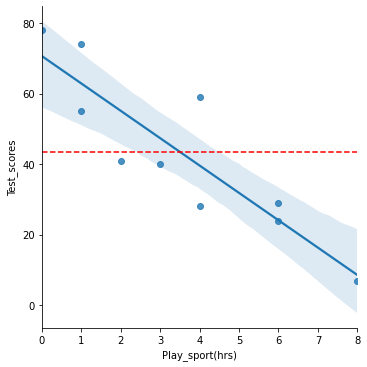

In [35]:
sns.lmplot(data=df, x='Play_sport(hrs)', y='Test_scores')

plt.axhline(df['Test_scores'].mean(), color='r', ls='--')

In this example, using the Iris dataset from sklearn, we can see that the baseline accuracy is around 60% while the SVC model's accuracy was improved to 95%. 

In [36]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC

In [37]:
X, y = load_iris(return_X_y=True)
y[y != 1] = -1    # this is done to create an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf_base = DummyClassifier(strategy='most_frequent', random_state=0)
clf_base.fit(X_train, y_train)
print(f"Baseline score is: {clf_base.score(X_test, y_test)}")

clf_model1 = SVC(kernel='linear', C=1).fit(X_train, y_train)
clf_model1.score(X_test, y_test)
print(f"SVC score is: {clf_model1.score(X_test, y_test)}")

clf_model2 = SVC(kernel='rbf', C=1).fit(X_train, y_train)
clf_model2.score(X_test, y_test)
print(f"SVC score is: {clf_model2.score(X_test, y_test)}")

Baseline score is: 0.5789473684210527
SVC score is: 0.631578947368421
SVC score is: 0.9473684210526315


When the accuracy of a classifier is too close to random, it probably means that something went wrong: features are not helpful, a hyperparameter is not correctly tuned, the classifier is suffering from class imbalance, etc…

<a id="metrics"></a>
<h2 align="center">EVALUATION METRICS</h2>

After we make predictions, we need to know if they are any good. There are standard measures that are used to summarize how good a set of predictions actually is. Knowing how good a set of predictions is allows us to make inferences about the performance of a given machine learning model. 

The metrics that we choose to evaluate the machine learning algorithms are very important. Choice of metrics influences how the performance of machine learning algorithms is measured and compared. They influence how we weight the importance of different characteristics in the results and our ultimate choice of which algorithm to choose.

**Performance metrics** like classification "accuracy" and regression "root mean squared error" can give us a clear objective idea of how good a set of predictions is, and in turn how good the model is that generated them. This is important as it allows us to tell the difference and select among:
- Different data transforms used to train the same machine learning model.
- Different machine learning models trained on the same data.
- Different machine learning model configurations trained on the same data.

There are many other performance metrics such as:
- Precision, Recall, F1 & Area Under ROC Curve or AUC for classification.
- Goodness of Fit or $R^2$ for regression.
- AIC & BIC

<a id="class"></a>
<h3 style="text-decoration:underline">Binary Classification Metrics</h3>

Classification problems are perhaps the most common type of machine learning problem and as such there are a myriad of metrics that can be used to evaluate predictions for these problems.

[For the full list of scoring options and metrics in scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)

In [38]:
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass',
         'pedi', 'age', 'target']
df_diab = pd.read_csv("./datasets/Evaluation Metrics/Diabetes.csv",
                      names=names)

X_diab = df_diab.drop(columns=['target'])
Y_diab = df_diab['target']
df_diab.head(2)

,preg,plas,pres,skin,test,mass,pedi,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


<a id="acc"></a>
<h5 style="text-decoration:underline">Accuracy</h5>

A quick way to evaluate a set of predictions on a classification problem is by using accuracy. **Classification accuracy** is a ratio of the number of correct predictions out of all predictions that were made. It is often presented as a percentage between 0% for the worst possible accuracy and 100% for the best possible accuracy.
>**This is the most common evaluation metric for classification problems, but also the most misused. It is really only suitable when there are an equal number of observations in each class (which is rarely the case) and that all predictions and prediction errors are equally important, which is often not the case.**
>>**Accuracy is a good metric to use when you have a small number of class values, such as 2, also called a binary classification problem. Accuracy starts to lose it’s meaning when you have more classes and you may need to review a different perspective on the results, such as a confusion matrix.**

The appeal of **accuracy** is that it has an intuitive and plain English explanation: *proportion of observations predicted correctly*. However, in the real world, often our data has imbalanced classes (e.g., the 99.9% of observations are of class 1 and only 0.1% are class 2). *When in the presence of imbalanced classes, accuracy suffers from a paradox where a model is highly accurate but lacks predictive power*. For example, imagine we are trying to predict the presence of a very rare cancer that occurs in 0.1% of the population. After training our model, we find the accuracy is at 95%. However, 99.9% of people do not have the cancer: if we simply created a model that “predicted” that nobody had that form of cancer, our naive model would be 4.9% more accurate, but clearly is not able to predict anything. For this reason, we are often motivated to use other metrics like precision, recall, and the $F_1$ score.

<a id="pre"></a>
<h5 style="text-decoration:underline">Precision</h5>

Precision can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. Said another way, "for all instances classified positive, what percent was correct?"

Precision is the proportion of every observation predicted to be positive that is actually positive. We can think about it as a measurement noise in our predictions - that is, when we predict something is positive, how likely we are to be right. Models with high precision are pessimistic in that they only predict an observation is of the positive class when they are very certain about it. 

<a id="rec"></a>
<h5 style="text-decoration:underline">Recall (sensitivity)</h5>

Recall is the proportion of every positive observation that is truly positive. Recall measures the model’s ability to identify an observation of the positive class. Models with high recall are optimistic in that they have a low bar for predicting that an observation is in the positive class.

Precision and recall are two extremely important model evaluation metrics. While precision refers to the percentage of the results which are relevant, recall refers to the percentage of total relevant results correctly classified by an algorithm.

<a id="f1"></a>
<h5 style="text-decoration:underline">F1</h5>

Almost always we want some kind of balance between precision and recall, and this role is filled by the $F_1$ score. The $F_1$ score is the harmonic mean (a kind of average used for ratios). It is a measure of correctness achieved in positive prediction - that is, of observations labeled as positive, how many are actually positive.

As an evaluation metric, accuracy has some valuable properties, especially its simple intuition. However, better metrics often involve using some balance of precision and recall - that is, a trade-off between the optimism and pessimism of our model. $F_1$ represents a balance between the recall and precision, where the relative contributions of both are equal.

<a id="cross"></a>
<h5 style="text-decoration:underline">Examples with `cross_val_score` and `cross_validate`</h5>

<table style='float:center;'>
    <tr>
        <td style='text-align: center; font-weight: bold; font-size: 15px;'>TP</td>
        <td style='text-align: center;'>Number of true positives. Observations that are<br>part of the positive class <b>and</b> predicted correctly.</td>
        <td style='text-align: center;'>$$\boldsymbol{Accuracy=\frac{TP+TN}{TP+TN+FP+FN}}$$</td>
    </tr>
    <tr>
        <td style='text-align: center; font-weight: bold; font-size: 15px;'>TN</td>
        <td style='text-align: center;'>Number of true negatives. Observations that are<br>part of the negatives class <b>and</b> predicted correctly.</td>
        <td style='text-align: center;'>$$\boldsymbol{Precision=\frac{TP}{TP+FP}}$$</td>
    </tr>
    <tr>
        <td style='text-align: center; font-weight: bold; font-size: 15px;'>FP</td>
        <td style='text-align: center;'>Number of false positives - <b>Type I error</b>.<br>Observations predicted to be part of the positive<br>class that are actually part of the negative class.</td>
        <td style='text-align: center;'>$$\boldsymbol{Recall=\frac{TP}{TP+FN}}$$</td>
    </tr>
    <tr>
        <td style='text-align: center; font-weight: bold; font-size: 15px;'>FN</td>
        <td style='text-align: center;'>Number of false negatives - <b>Type II error</b>.<br>Observations predicted to be part of the negative<br>class that are actually part of the positive class.</td>
        <td style='text-align: center;'>$$\boldsymbol{F_1=2\times\frac{Precision\times Recall}{Precision+Recall}}$$</td>
    </tr>

We can substitute the different scoring metrics in the `cross_val_score`.

In [39]:
model = LogisticRegression(max_iter=300)

kfold = KFold(n_splits=10)
results = cross_val_score(model, X_diab, Y_diab, cv=kfold, scoring='accuracy')

print('Scores:', results.round(4))
print('-'*79)
print(f"Accuracy: {results.mean():.3f} +/- ({results.std():.{2}})")

Scores: [0.6883 0.8182 0.7662 0.6883 0.7792 0.7922 0.8442 0.8312 0.75   0.8026]
-------------------------------------------------------------------------------
Accuracy: 0.776 +/- (0.052)


Or we can use multiple scoring metrics using `cross_validate` and access them via the **scores** dictionary.

In [40]:
from sklearn.model_selection import cross_validate

In [41]:
model = LogisticRegression(max_iter=300)

kfold = KFold(n_splits=10)
scores = cross_validate(model, X_diab, Y_diab, cv=kfold, scoring='accuracy')

print('Dictionary keys:', scores.keys())
print('-'*68)
print(scores['test_score'].round(4))
print('-'*71)
print(f"Accuracy: {scores['test_score'].mean():.3f} +/- ({scores['test_score'].std():.{2}})")

Dictionary keys: dict_keys(['fit_time', 'score_time', 'test_score'])
--------------------------------------------------------------------
[0.6883 0.8182 0.7662 0.6883 0.7792 0.7922 0.8442 0.8312 0.75   0.8026]
-----------------------------------------------------------------------
Accuracy: 0.776 +/- (0.052)


In [42]:
model = LogisticRegression(max_iter=300)

kfold = KFold(n_splits=10)
scores = cross_validate(model, X_diab, Y_diab, cv=kfold, 
                        scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Dictionary keys:', scores.keys())
print('-'*115)
print(scores['test_accuracy'].round(4))
print('-'*71)
print(f"Accuracy: {scores['test_accuracy'].mean():.3f} +/- ({scores['test_accuracy'].std():.{2}})")
print(f"Precision: {scores['test_precision'].mean():.3f} +/- ({scores['test_precision'].std():.{2}})")
print(f"Recall: {scores['test_recall'].mean():.3f} +/- ({scores['test_recall'].std():.{2}})")
print(f"F1: {scores['test_f1'].mean():.3f} +/- ({scores['test_f1'].std():.{2}})")

Dictionary keys: dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1'])
-------------------------------------------------------------------------------------------------------------------
[0.6883 0.8182 0.7662 0.6883 0.7792 0.7922 0.8442 0.8312 0.75   0.8026]
-----------------------------------------------------------------------
Accuracy: 0.776 +/- (0.052)
Precision: 0.724 +/- (0.1)
Recall: 0.581 +/- (0.044)
F1: 0.641 +/- (0.054)


>**Note: We can check the scores within cross-validation or [we can call the metrics directly](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) if we already have the true y values and the predicted y values.**

<a id="prc"></a>
<h5 style="text-decoration:underline">Visualize Precision-Recall Curves For Binary Classification</h5>

The **Precision-Recall-Curve** shows the tradeoff between a classifier’s precision, a measure of result relevancy, and recall, a measure of completeness. For each class, precision is defined as the ratio of true positives to the sum of true and false positives, and recall is the ratio of true positives to the sum of true positives and false negatives.

Both precision and recall vary between 0 and 1, and in the efforts to select and tune machine learning models, the goal is often to try to maximize both precision and recall, i.e. a model that returns accurate results for the majority of classes it selects. This would result in a Precision-Recall-Curve visualization with a high area under the curve.

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).
- A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. 
- A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. 
- An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Precision-recall curves are typically used in binary classification to study the output of a classifier. In order to extend the precision-recall curve and average precision to multi-class or multi-label classification, it is necessary to binarize the output. One curve can be drawn per label, but one can also draw a precision-recall curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

In [43]:
from yellowbrick.classifier import PrecisionRecallCurve

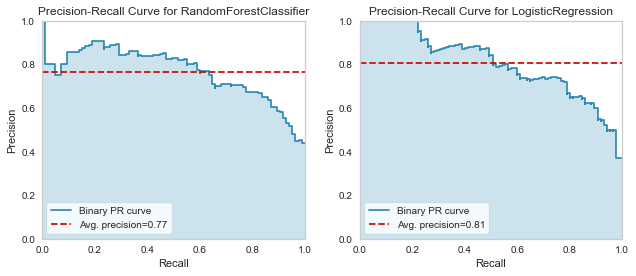

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_diab, Y_diab,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=1)

# Create the visualizers, fit, score, and show them
models = [RandomForestClassifier(random_state=1), 
          LogisticRegression(random_state=1)]

fig, axes = plt.subplots(ncols=2, figsize=(9,4))

for i, ax in enumerate(axes.flatten()):
    viz = PrecisionRecallCurve(models[i], ax=ax, show=False)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.tight_layout()

One way to use `PrecisionRecallCurves` is for model comparison, by examining which has the highest average precision. For instance, the above visualization suggest that a LogisticRegression model might be better than a RandomForestClassifier for this particular dataset.
>**Precision-recall curves are one of the methods used to evaluate a classifier’s quality, particularly when classes are very imbalanced.**

In [45]:
from sklearn.metrics import PrecisionRecallDisplay

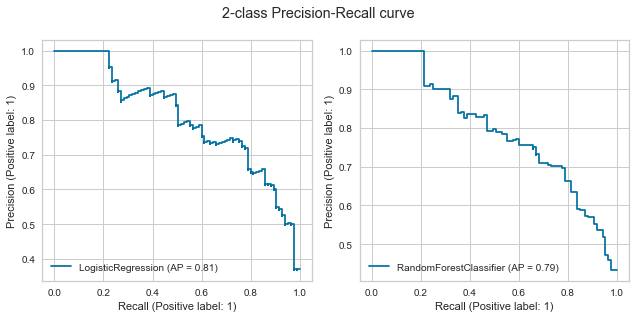

In [46]:
pipe1 = Pipeline(steps=[('std', StandardScaler()),
                        ('mod', LogisticRegression())])
pipe2 = Pipeline(steps=[('std', StandardScaler()),
                        ('mod', RandomForestClassifier())])

models=[pipe1, pipe2]

fig, axes = plt.subplots(ncols=2, figsize=(9,4.5))

for i, ax in enumerate(axes.flatten()):
    models[i].fit(X_train, y_train)
    
    display = PrecisionRecallDisplay.from_estimator(
    models[i], X_test, y_test, 
        name=str(models[i].steps[1][1]).replace('()',''),
        ax=ax)

# _ = display.ax_.set_title("2-class Precision-Recall curve")

fig.suptitle("2-class Precision-Recall curve")
plt.tight_layout()

In [47]:
pipe1 = Pipeline(steps=[('std', StandardScaler()),
                        ('mod', LogisticRegression())])
pipe1.fit(X_train, y_train)

Pipeline(steps=[('std', StandardScaler()), ('mod', LogisticRegression())])

If we already got the estimated probabilities or scores for our model, then we can use **from_predictions**.
```python
PrecisionRecallDisplay.from_predictions(y_test, y_score,
                                        name="LogisticRegression")
```

<a id="log"></a>
<h5 style="text-decoration:underline">Logarithmic Loss</h5>

**Logarithmic loss (or logloss)** is a performance metric for evaluating the predictions of probabilities of membership to a given class. The scalar probability between 0 and 1 can be seen as a measure of confidence for a prediction by an algorithm. Predictions that are correct or incorrect are rewarded or punished proportionally to the confidence of the prediction.

In [48]:
model = LogisticRegression(max_iter=300)

kfold = KFold(n_splits=10)
results = cross_val_score(model, X_diab, Y_diab, cv=kfold, scoring='neg_log_loss')

print(f"Logloss: {results.mean():.3f} +\- ({results.std():.3f})")

Logloss: -0.484 +\- (0.062)


In [49]:
model = LogisticRegression(max_iter=300)

kfold = KFold(n_splits=10)
results = cross_validate(model, X_diab, Y_diab, cv=kfold, scoring='neg_log_loss')
# results.keys()
print(f"Logloss: {results['test_score'].mean():.3f} +/- ({results['test_score'].std():.3f})")

Logloss: -0.484 +/- (0.062)


Smaller logloss is better with 0 representing a perfect logloss. The measure is inverted (made negative) to be ascending when using the `cross_val_score()` function.

<a id="roc"></a>
<h5 style="text-decoration:underline">Area Under ROC Curve</h5>

The **Receiving Operating Characteristic (ROC) curve** is a common method for evaluating the quality of a binary classifier. ROC compares the presence of true positives and false positives at every probability threshold (i.e., the probability at which an observation is predicted to be a class). In other words, the ROC curve represents a model’s ability to discriminate between positive and negative classes.

By plotting the ROC curve, we can see how the model performs. A classifier that predicts every observation correctly would look like the solid light gray line in the following chart, going straight up to the top immediately. This would be represented by an `roc_auc` score of 1.0. A classifier that predicts at random will appear as the green diagonal line with an `roc_auc` score of 0.5. The better the model, the closer it is to the solid line. In scikit-learn, we can use `roc_curve` to calculate the true and false positives at each threshold, then plot them.

ROC can be broken down into sensitivity and specificity. A binary classification problem is really a trade-off between sensitivity and specificity.
- **Sensitivity** is the true positive rate also called the recall. It is the number of instances from the positive (first) class that actually predicted correctly.
- **Specificity** is the true negative rate. It is the number of instances from the negative (second) class that were actually predicted correctly.

In [50]:
model = LogisticRegression(max_iter=300)

kfold = KFold(n_splits=10)
# results = cross_val_score(model, X_diab, Y_diab, cv=kfold, scoring='roc_auc')
results = cross_validate(model, X_diab, Y_diab, cv=kfold, scoring='roc_auc')

# print(f"AUC: {results.mean():.3f} +/- ({results.std():.3f})")
print(f"AUC: {results['test_score'].mean():.3f} +/- ({results['test_score'].std():.3f})")

AUC: 0.828 +/- (0.043)


In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

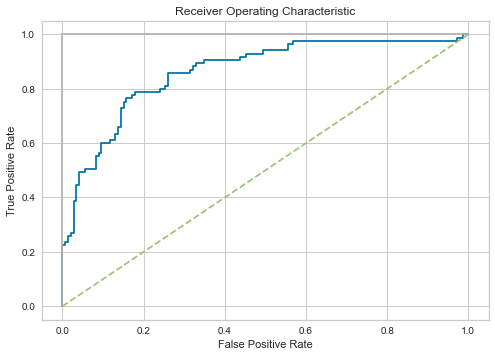

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_diab, Y_diab,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=1)
# Create classifier
pipe = Pipeline(steps=[('std', StandardScaler()),
                       ('mod', LogisticRegression(max_iter=300))])

pipe.fit(X_train, y_train)

# Only need the first column of values - the negative class(0)
probabilities = pipe.predict_proba(X_test)[:,1]

# Create true and false positive rates
false_pos_rate, true_pos_rate, threshold = roc_curve(y_test,
                                                     probabilities)
# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_pos_rate, true_pos_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [53]:
# probabilities for the first test value
pipe.predict_proba(X_test)[0]

array([0.57740783, 0.42259217])

In this example, the first observation has an ~58% chance of being in the negative class (0) and a 42% chance of being in the positive class (1). By default, scikit-learn predicts an observation is part of the positive class if the probability is greater than 0.5 (called the threshold). However, instead of a middle ground, we will often want to explicitly bias our model to use a different threshold for substantive reasons.

For example, if a false positive is very costly to a company, we might prefer a model that has a high probability threshold. We fail to predict some positives, but when an observation is predicted to be positive, we can be very confident that the prediction is correct. This trade off is represented in the true positive rate (TPR) and the false positive rate (FPR). The true positive rate is the number of observations correctly predicted true divided by all true positive observations:
$$TPR=\frac{True Positives}{True Positives + False Negatives}$$
The false positive rate is the number of incorrectly predicted positives divided by all true negative observations: 
$$FPR=\frac{False Positives}{False Positives + True Negatives}$$
The ROC curve represents the respective TPR and FPR for every probability threshold.

Based on the above example, a threshold of roughly 0.50 has a TPR of 0.56 and an FPR of 0.096.

In [54]:
df = pd.DataFrame({'FPR':false_pos_rate, 'TPR':true_pos_rate, 'thresh':threshold})
df[(df['thresh']>0.49) & (df['thresh']<0.6)]

,FPR,TPR,thresh
18,0.082192,0.552941,0.588349
19,0.089041,0.552941,0.582655
20,0.089041,0.564706,0.579613
21,0.095890,0.564706,0.562463


However, if we increase the threshold to ~80% (i.e., increase how certain the
model has to be before it predicts an observation as positive) the TPR drops
significantly but so does the FPR:

In [55]:
df[(df['thresh']>0.77) & (df['thresh']<0.9)]

,FPR,TPR,thresh
2,0.000000,0.223529,0.777947
3,0.006849,0.223529,0.775258


This is because our higher requirement for being predicted to be in the positive class has made the model not identify a number of positive observations (the lower TPR), but also reduce the noise from negative observations being predicted as positive (the lower FPR). In addition to being able to visualize the trade-off between TPR and FPR, the ROC curve can also be used as a general metric for a model. The better a model is, the higher the curve and thus the greater the area under the curve. For this reason, it is common to calculate the area under the ROC curve (AUCROC) to judge the overall equality of a model at all possible thresholds. The closer the AUCROC is to 1, the better the model. 

In [56]:
roc_auc_score(y_test,probabilities)

0.8633360193392425

In [57]:
from yellowbrick.classifier import ROCAUC

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


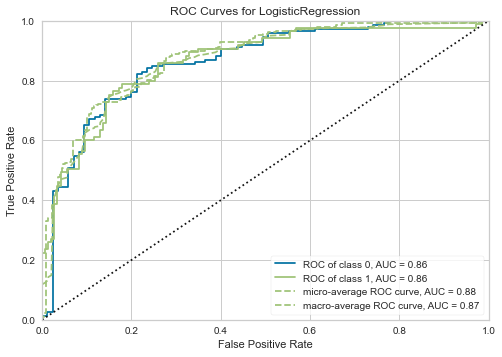

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [58]:
visualizer = ROCAUC(pipe, classes=[0,1])

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.show()                    # Finalize and show the figure

<a id="disc"></a>
<h5 style="text-decoration:underline">Discrimination Threshold</h5>

A visualization of precision, recall, f1 score, and queue rate with respect to the discrimination threshold of a binary classifier. The discrimination threshold is the probability or score at which the positive class is chosen over the negative class. Generally, this is set to 50% but the threshold can be adjusted to increase or decrease the sensitivity to false positives or to other application factors.

In [59]:
from yellowbrick.classifier import DiscriminationThreshold

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


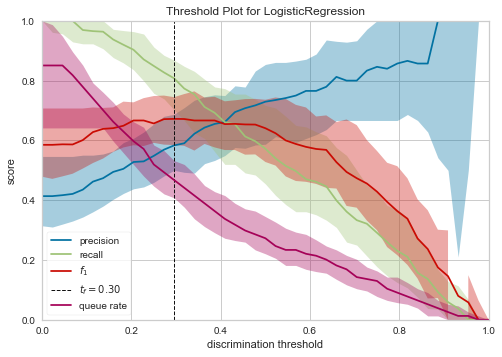

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [60]:
visualizer = DiscriminationThreshold(pipe)

visualizer.fit(X_diab, Y_diab)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

One common use of binary classification algorithms is to use the score or probability they produce to determine cases that require special treatment. For example, a fraud prevention application might use a classification algorithm to determine if a transaction is likely fraudulent and needs to be investigated in detail. In the figure above, we present an example where a binary classifier determines if an email is “spam” (the positive case) or “not spam” (the negative case). Emails that are detected as spam are moved to a hidden folder and eventually deleted.

Many classifiers use either a decision_function to score the positive class or a predict_proba function to compute the probability of the positive class. If the score or probability is greater than some discrimination threshold then the positive class is selected, otherwise, the negative class is.

Generally speaking, the threshold is balanced between cases and set to 0.5 or 50% probability. However, this threshold may not be the optimal threshold: often there is an inverse relationship between precision and recall with respect to a discrimination threshold. By adjusting the threshold of the classifier, it is possible to tune the F1 score (the harmonic mean of precision and recall) to the best possible fit or to adjust the classifier to behave optimally for the specific application. Classifiers are tuned by considering the following metrics:

- **precision** - An increase in precision is a reduction in the number of false positives; this metric should be optimized when the cost of special treatment is high (e.g. wasted time in fraud preventing or missing an important email).

- **Recall** - An increase in recall decrease the likelihood that the positive class is missed; this metric should be optimized when it is vital to catch the case even at the cost of more false positives.

- **F1 Score** - The F1 score is the harmonic mean between precision and recall. The fbeta parameter determines the relative weight of precision and recall when computing this metric, by default set to 1 or F1. Optimizing this metric produces the best balance between precision and recall.

- **Queue Rate** - The "queue" is the spam folder or the inbox of the fraud investigation desk. This metric describes the percentage of instances that must be reviewed. If review has a high cost (e.g. fraud prevention) then this must be minimized with respect to business requirements; if it doesn’t (e.g. spam filter), this could be optimized to ensure the inbox stays clean.

In the figure above we see the visualizer tuned to look for the optimal F1 score, which is annotated as a threshold of 0.31. The model is run multiple times over multiple train/test splits in order to account for the variability of the model with respect to the metrics (shown as the fill area around the median curve).

In [61]:
from sklearn.neighbors import KNeighborsClassifier

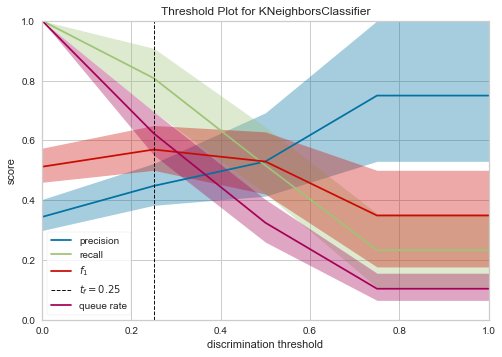

<AxesSubplot:title={'center':'Threshold Plot for KNeighborsClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [62]:
visualizer = DiscriminationThreshold(KNeighborsClassifier(3))
visualizer.fit(X_diab, Y_diab)
visualizer.show()

<a id="multi"></a>
<h3 style="text-decoration:underline">Multiclass Classification Metrics</h3>

Many of scikit-learn’s built-in metrics are for evaluating binary classifiers. However, many of these metrics can be extended for use when we have more than two classes. Precision, recall, and F1 scores are useful metrics that we have already covered in detail in previous recipes. While all of them were originally designed for binary classifiers, we can apply them to multiclass settings by treating the data as a set of binary classes. Doing so enables us to apply the metrics to each class as if it were the only class in the data, and then aggregate the evaluation scores for all the classes by averaging them.

When we have balanced classes (e.g., a roughly equal number of observations in each class of the target vector), accuracy is - just like in the binary class setting - a simple and interpretable choice for an evaluation metric. Accuracy is the number of correct predictions divided by the number of observations and works just as well in the multiclass as binary setting. However, when we have imbalanced classes (a common scenario), we should be inclined to use other evaluation metrics. 

In [63]:
# Generate features matrix and target vector
features, target = make_classification(n_samples = 10000, n_features = 5,
                                       n_informative = 3, n_redundant = 1,
                                       n_classes = 3, random_state = 1)

X_clas = pd.DataFrame(features, columns=[f'Col_{i}' for i in range(1,6)])
y_clas = pd.Series(target)

In [64]:
y_clas.value_counts()

0    3340
1    3338
2    3322
dtype: int64

In [65]:
# Create classifier
pipe = Pipeline(steps=[('std', StandardScaler()),
                       ('mod', LogisticRegression(max_iter=300))])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_validate(pipe, X_clas, y_clas, cv=cv, 
                        scoring=['accuracy', 'precision_micro',
                                 'recall_weighted', 'f1_macro'])

print('Dictionary keys:', scores.keys())
print('-'*136)
print(f"Accuracy: {scores['test_accuracy'].mean():.3f} +/- ({scores['test_accuracy'].std():.{2}})")
print(f"Precision_micro: {scores['test_precision_micro'].mean():.3f} +/- ({scores['test_precision_micro'].std():.{2}})")
print(f"Recall_weighted: {scores['test_recall_weighted'].mean():.3f} +/- ({scores['test_recall_weighted'].std():.{2}})")
print(f"F1_macro: {scores['test_f1_macro'].mean():.3f} +/- ({scores['test_f1_macro'].std():.{2}})")

Dictionary keys: dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision_micro', 'test_recall_weighted', 'test_f1_macro'])
----------------------------------------------------------------------------------------------------------------------------------------
Accuracy: 0.827 +/- (0.015)
Precision_micro: 0.827 +/- (0.015)
Recall_weighted: 0.827 +/- (0.015)
F1_macro: 0.826 +/- (0.015)


The `scoring` in the above example refers to the method used to average the evaluation scores from the classes.
- **macro** - Calculate the mean of metric scores for each class, weighting each class equally.
- **weighted** - Calculate the mean of metric scores for each class, weighting each class proportional to its size in the data.
- **micro** - Calculate the mean of metric scores for each observation-class combination.

<a id="prmc"></a>
<h5 style="text-decoration:underline">Visualize Precision-Recall Curves For Multi-Class Classification</h5>

To support multi-label classification, the estimator is wrapped in a [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) to produce binary comparisons for each class (e.g. the positive case is the class and the negative case is any other class). The precision-recall curve can then be computed as the micro-average of the precision and recall for all classes (by setting `micro=True`), or individual curves can be plotted for each class (by setting `per_class=True`)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_clas, y_clas,
                                                    test_size=0.3,
                                                    random_state=1)

<ins>`Using Yellowbrick`</ins>

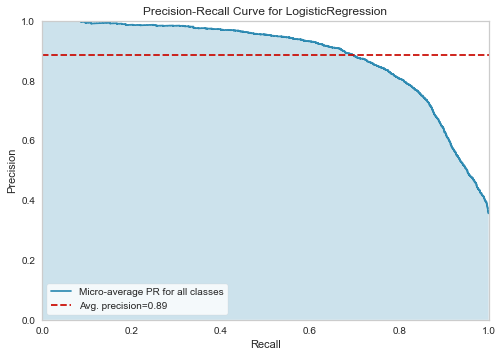

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [67]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(pipe, micro=True, per_class=False, cmap="Set1")
# viz = PrecisionRecallCurve(pipe, micro=False, per_class=True, cmap="Set1")
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

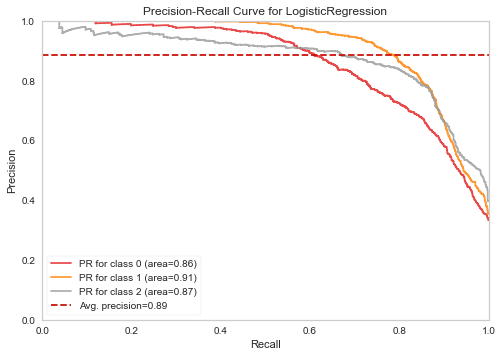

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [68]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(pipe, micro=False, per_class=True, cmap="Set1")
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

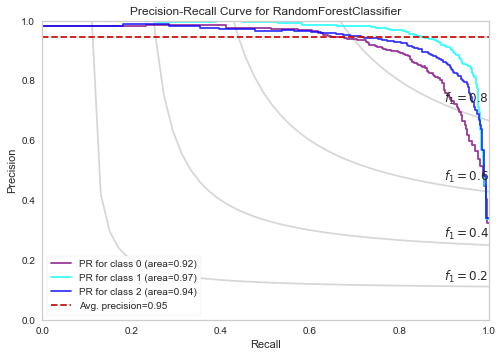

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [69]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(RandomForestClassifier(), classes=[0,1,2],
                           colors=["purple", "cyan", "blue"],
                           iso_f1_curves=True, per_class=True,
                           micro=False)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

<ins>`Using Sklearn`</ins>

In [70]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

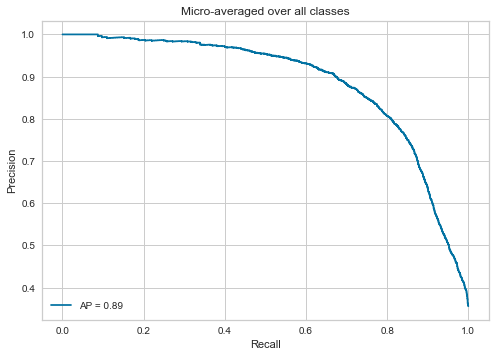

In [71]:
y_clas_bin = label_binarize(y_clas, classes=[0, 1, 2])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_clas, y_clas_bin,
                                                        test_size=0.3,
                                                        random_state=1)

model = OneVsRestClassifier(Pipeline(steps=[('std', StandardScaler()),
                                            ('mod', LogisticRegression())]))

model.fit(X_train2, y_train2)
y_score = model.decision_function(X_test2)

# The average precision score in multi-label settings
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = y_clas_bin.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test2[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test2[:, i],
                                                   y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test2.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test2, y_score, 
                                                     average="micro")

# Plot the micro-averaged Precision-Recall curve
display = PrecisionRecallDisplay(recall=recall["micro"],
                                 precision=precision["micro"],
                                 average_precision=average_precision["micro"])
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

In [72]:
from itertools import cycle

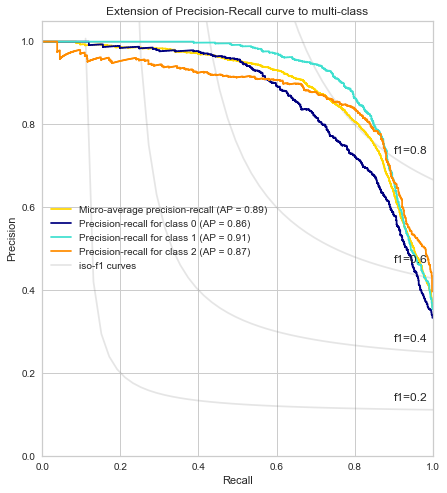

In [73]:
# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(recall=recall["micro"],
                                 precision=precision["micro"],
                                 average_precision=average_precision["micro"])
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(recall=recall[i],
                                     precision=precision[i],
                                     average_precision=average_precision[i])
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])

# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

<a id="mcroc"></a>
<h5 style="text-decoration:underline">Multi-class ROCAUC Curves</h5>

<ins>`Using Yellowbrick`</ins>

Yellowbrick’s `ROCAUC` Visualizer does allow for plotting multiclass classification curves. ROC curves are typically used in binary classification, and in fact the Scikit-Learn `roc_curve` metric is only able to perform metrics for binary classifiers. **Yellowbrick addresses this by binarizing the output (per-class) or to use one-vs-rest (micro score) or one-vs-all (macro score) strategies of classification**.

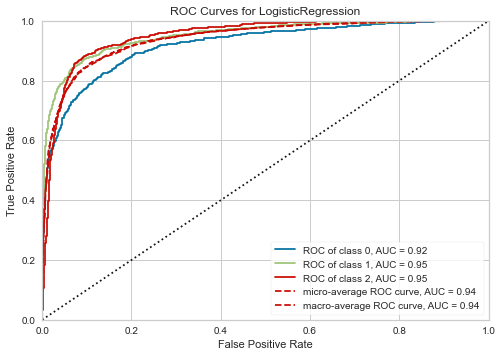

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
visualizer = ROCAUC(pipe)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.show()  

<ins>`Using Sklearn`</ins>

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

Another evaluation measure for multi-label classification is macro-averaging, which gives equal weight to the classification of each label.

In [75]:
n_classes = y_clas_bin.shape[1]
print(f'Number of classes in the target variable: {n_classes}')

Number of classes in the target variable: 3


In [76]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [77]:
# Learn to predict each class against the other
model = OneVsRestClassifier(Pipeline(steps=[('std', StandardScaler()),
                                            ('mod', LogisticRegression())]))
model.fit(X_train2, y_train2)
y_score = model.decision_function(X_test2)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

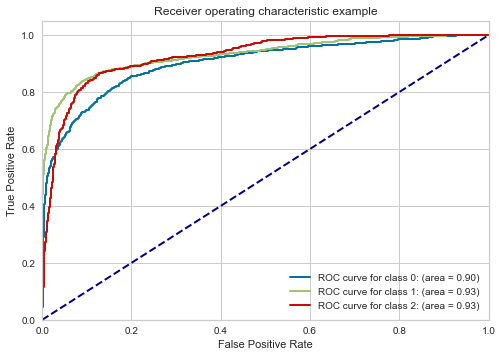

In [78]:
# Plot of ROC curve for each specific class

for i,col in zip(range(3),['b','g','r']):
    plt.plot(fpr[i], tpr[i], color=col, lw=2,
         label=f"ROC curve for class {i}: (area = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [79]:
# Plot ROC curves for the multiclass problem

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

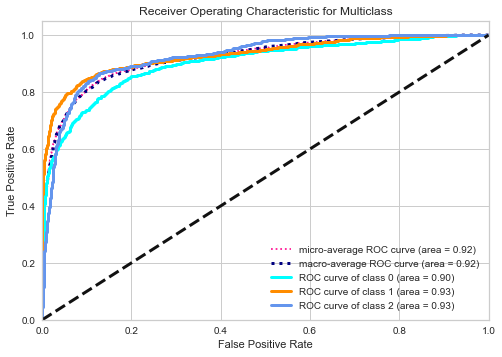

In [80]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", 
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')

plt.plot(fpr["macro"],tpr["macro"],color="navy",linestyle=":", lw=3,
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})')

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot( fpr[i], tpr[i], color=color, lw=3, 
             label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic for Multiclass")
plt.legend(loc="lower right")
plt.show()

The multi-class One-vs-One scheme compares every unique pairwise combination of classes. Below, we calculate the AUC using the OvR and OvO schemes. We report the macro average, and a prevalence-weighted average.

In [81]:
y_prob = model.predict_proba(X_test2)

macro_roc_auc_ovo = roc_auc_score(y_test2, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test2, y_prob, 
                                     multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test2, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test2, y_prob, multi_class="ovr",
                                     average="weighted")
print(
    f"One-vs-One ROC AUC scores:\n{macro_roc_auc_ovo:.6f} (macro),\n{weighted_roc_auc_ovo:.6f} "
    "(weighted by prevalence)")
print(
    f"One-vs-Rest ROC AUC scores:\n{macro_roc_auc_ovr:.6f} (macro),\n{weighted_roc_auc_ovr:.6f} "
    "(weighted by prevalence)")

One-vs-One ROC AUC scores:
0.920402 (macro),
0.920662 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.920402 (macro),
0.920662 (weighted by prevalence)


<a id="matrix"></a>
<h5 style="text-decoration:underline">Confusion Matrix</h5>

The **confusion matrix** is a handy presentation of the accuracy of a model with two or more classes. The table presents predictions on the x-axis and accuracy outcomes on the y-axis. The cells of the table are the number of predictions made by a machine learning algorithm.a A confusion matrix is always a good idea to use in addition to classification accuracy to help interpret the predictions.
>**The value of a confusion matrix for classification problems is that you can clearly see which predictions were wrong and the type of mistake that was made.**

In [82]:
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)
matrix = confusion_matrix(y_test, predictions, normalize=None)
matrix

array([[752,  81, 138],
       [135, 853,  23],
       [ 88,  60, 870]], dtype=int64)

Although the array is printed without headings, we can see that the majority of the predictions fall on the diagonal line of the matrix (which are correct predictions).

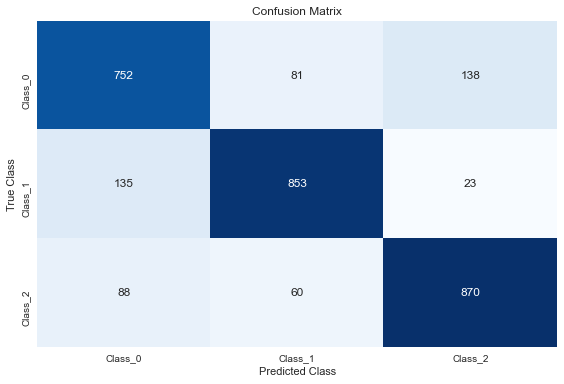

In [83]:
class_names = ['Class_0', 'Class_1', "Class_2"]

# Create pandas dataframe
df = pd.DataFrame(matrix, index=class_names, columns=class_names)

# Create heatmap
sns.heatmap(df, annot=True, cbar=None, cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

In [84]:
from yellowbrick.classifier import ConfusionMatrix

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


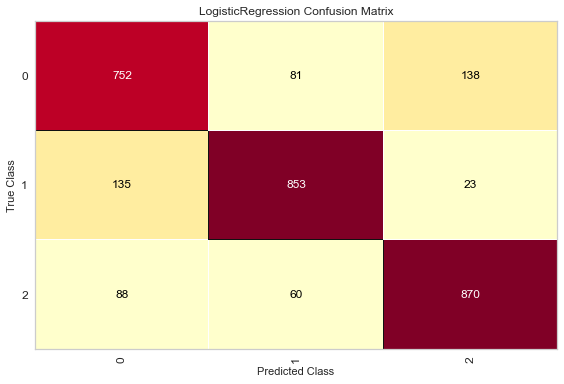

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [85]:
# pipe.fit(X_train, y_train)

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(pipe, classes=[0,1,2], 
                     label_encoder={0: 'Class_0', 1: 'Class_1', 2: 'Class_2'})

# Fit fits the passed model. 
# This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

Confusion matrices are an easy, effective visualization of a classifier’s performance. One of the major benefits of confusion matrices is their interpretability. Each column of the matrix (often visualized as a heatmap) represents predicted classes, while every row shows true classes. The end result is that every cell is one possible combination of predict and true classes. 

There are three things worth noting about confusion matrices. 
- First, a perfect model will have values along the diagonal and zeros everywhere else. A bad model will look like the observation counts will be spread evenly around cells. 
- Second, a confusion matrix lets us see not only where the model was wrong, but also how it was wrong. That is, we can look at patterns of misclassification.
- Finally, confusion matrices work with any number of classes.

<a id="report"></a>
<h5 style="text-decoration:underline">Classification Report</h5>

The scikit-learn library provides a convenience report when working on classification problems to give you a quick idea of the accuracy of a model using a number of measures. The **classification report** displays the precision, recall, F1-score and support for each class.

In [86]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.77      0.77      0.77       971
     class 1       0.86      0.84      0.85      1011
     class 2       0.84      0.85      0.85      1018

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.83      0.82      0.83      3000



In [87]:
from yellowbrick.classifier import ClassificationReport

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


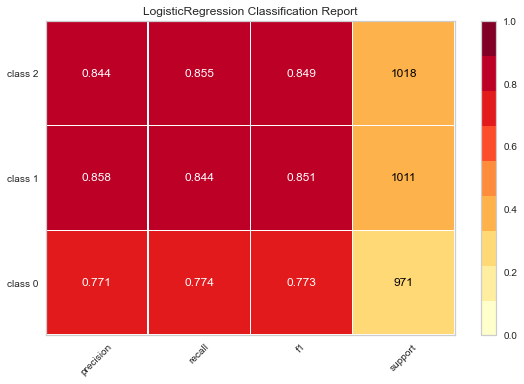

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [88]:
visualizer = ClassificationReport(pipe, classes=target_names, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem. Visual classification reports are used to compare classification models to select models that are "redder", e.g. have stronger classification metrics or that are more balanced.

**Precision** can be seen as a measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. Said another way, "for all instances classified positive, what percent was correct?"

**Recall** is a measure of the classifier’s completeness; the ability of a classifier to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, "for all instances that were actually positive, what percent was classified correctly?"

The **F1 score** is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

**Support** is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

<a id="reg"></a>
<h3 style="text-decoration:underline">Regression Metrics</h3>

In [89]:
from sklearn.linear_model import LinearRegression

In [90]:
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
         'DIS', 'RAD', 'TAX', 'PTRATIO','B', 'LSTAT', 'MEDV']

df_hous = pd.read_csv("./datasets/Evaluation Metrics/boston_housing.csv",
                      names=names)

X_hous = df_hous.drop(columns=['MEDV'])
Y_hous = df_hous['MEDV']
df_hous.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


<a id="mae"></a>
<h5 style="text-decoration:underline">Mean Absolute Error</h5>

Regression problems are those where a real value is predicted. An easy metric to consider is the error in the predicted values as compared to the expected values. The **Mean Absolute Error (MAE)** is a good first error metric to use. It is calculated as the average of the absolute error values (difference between predictions and actual values). The measure gives an idea of the magnitude of the error, but no idea of the direction (e.g. over or under predicting).
$$MAE=\frac{\Sigma{abs(predicted_i-actual_i)}}{\text{no. of predictions}}$$

In [91]:
model = LinearRegression()

kfold = KFold(n_splits=10)
results = cross_val_score(model, X_hous, Y_hous,
                          cv=kfold, scoring='neg_mean_absolute_error')

print(f"MAE: {results.mean():.3f} +/- ({results.std():.3f})")

MAE: -4.005 +/- (2.084)


<a id="mse"></a>
<h5 style="text-decoration:underline">Mean Squared Error</h5>

**Mean Squared Error (or MSE)** is one of the most common evaluation metrics for regression models. 
$$MSE = \frac{1}{n}\sum{(\hat{y}_i-y_i)^2}$$
where $n$ is the number of observations, $y_i$ is the true value of the target, and $\hat{y}_i$ is the model’s predicted value. The higher the value of MSE, the greater the total squared error and thus the worse the model. 
- There are a number of mathematical benefits to squaring the error term, including that it forces all error values to be positive, but one often unrealized implication is that squaring penalizes a few large errors more than many small errors, even if the absolute value of the errors is the same.

The MSE is much like the mean absolute error in that it provides a gross idea of the magnitude of error. Taking the square root of the mean squared error converts the units back to the original units of the output variable and can be meaningful for description and presentation.

>**Note: By default in scikit-learn, arguments of the `scoring` parameter assume that higher values are better than lower values. However, this is not the case for MSE, where higher values mean a worse model. For this reason, scikit-learn looks at the negative MSE using the `neg_mean_squared_error` argument.**

In [92]:
model = LinearRegression()

kfold = KFold(n_splits=10)
results = cross_val_score(model, X_hous, Y_hous,
                          cv=kfold, scoring='neg_mean_squared_error')

print(f"MSE: {results.mean():.3f} +/- ({results.std():.3f})")

MSE: -34.705 +/- (45.574)


This metric too is inverted (made negative) so that the results are increasing (closer to zero the better). Remember to take the absolute value before taking the square root if you are interested in calculating the RMSE.

<a id="rmse"></a>
<h5 style="text-decoration:underline">Root Mean Squared Error</h5>

Another popular way to calculate the error in a set of regression predictions is to use the **Root Mean Squared Error (RMSE)**. RMSE is calculated as the square root of the mean of the squared differences between actual outcomes and predictions. Squaring each error forces the values to be positive, and the square root of the mean squared error returns the error metric back to the original units for comparison.
$$RMSE=\sqrt{\frac{\Sigma{(predicted_i-actual_i)^2}}{\text{no. of predictions}}}$$

<a id="squared"></a>
<h5 style="text-decoration:underline">R-squared $R^2$</h5>

The **$R^2$** metric provides an indication of the goodness of fit of a set of predictions to the actual values. In statistical literature this measure is called the coefficient of determination and measures the amount of variance in the target vector that is explained by the model. This is a value between 0 and 1 for no-fit and perfect fit respectively.

One small note regarding score. By default, score returns the coefficient of
determination (R-squared, $R_2$) score:
$$R^2 = 1-\frac{\sum(y_i-\hat{y}_i)^2}{\sum(y_i-\bar{y})^2}$$
where $y_i$ is the true value of the target observation, $\hat{y}_i$ is the predicted value, and $\bar{y}$ is the mean value for the target vector.

The closer $R_2$ is to 1, the more of the variance in the target vector that is explained by the features.

In [93]:
model = LinearRegression()

kfold = KFold(n_splits=10)
results = cross_val_score(model, X_hous, Y_hous, cv=kfold, scoring='r2')

print(f"R_squared: {results.mean():.3f} +/- ({results.std():.3f})")

R_squared: 0.203 +/- (0.595)


The predictions have a poor fit to the actual values with a value closer to zero and less than 0.5.

In [94]:
model = LinearRegression()

kfold = KFold(n_splits=10)
scores = cross_validate(model, X_hous, Y_hous, cv=kfold, 
                         scoring=['neg_mean_absolute_error', 'neg_mean_squared_error',
                                 'neg_root_mean_squared_error', 'r2','explained_variance'])

print(f"MAE: {scores['test_neg_mean_absolute_error'].mean():.3f} +/- ({scores['test_neg_mean_absolute_error'].std():.{3}})")
print(f"MSE: {scores['test_neg_mean_squared_error'].mean():.3f} +/- ({scores['test_neg_mean_squared_error'].std():.{3}})")
print(f"RMSE: {scores['test_neg_root_mean_squared_error'].mean():.3f} +/- ({scores['test_neg_root_mean_squared_error'].std():.{3}})")
print(f"R^2: {scores['test_r2'].mean():.3f} +/- ({scores['test_r2'].std():.{3}})")
print(f"Explained_Variance: {scores['test_explained_variance'].mean():.3f} +/- ({scores['test_explained_variance'].std():.{3}})")

MAE: -4.005 +/- (2.08)
MSE: -34.705 +/- (45.6)
RMSE: -5.181 +/- (2.8)
R^2: 0.203 +/- (0.595)
Explained_Variance: 0.273 +/- (0.513)


<a id="clust"></a>
<h3 style="text-decoration:underline">Clustering Metrics</h3>

Supervised model evaluation compares predictions (e.g., classes or quantitative values) with the corresponding true values in the target vector. However, the most common motivation for using clustering methods is that the data doesn’t have a target vector. There are a number of clustering evaluation metrics that require a target vector, but again, using unsupervised learning approaches like clustering when you have a target vector available to you is probably handicapping yourself unnecessarily.

<a id="sil"></a>
<h5 style="text-decoration:underline">Silhouette Score</h5>

While we cannot evaluate predictions versus true values if we don’t have a target vector, we can evaluate the nature of the clusters themselves. Intuitively, we can imagine "good" clusters having very small distances between observations in the same cluster (i.e. dense clusters) and large distances between the different clusters (i.e. well-separated clusters). Silhouette coefficients provide a single value measuring both traits. Formally, the $i$th observation’s silhouette coefficient is:
$$s_i=\frac{b_i-a_i}{max(a_i,b_i)}$$
where $s_i$ is the silhouette coefficient for observation $i$, $a_i$ is the mean distance between $i$ and all observations of the same class, and $b_i$ is the mean distance between $i$ and all observations from the closest cluster of a different class. The value returned by **`silhouette_score`** is the mean silhouette coefficient for all observations. Silhouette coefficients range between –1 and 1, with 1 indicating dense, well-separated clusters.

In [95]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [96]:
# Generate feature matrix
features, _ = make_blobs(n_samples = 1000, n_features = 10, centers = 3,
                         cluster_std = 0.5, shuffle = True, random_state = 1)

# Cluster data using k-means to predict classes
model = KMeans(n_clusters=2, random_state=1).fit(features)

# # Get predicted classes - equivalent to model.predict(features)
target_predicted = model.labels_

# Evaluate model
silhouette_score(features, target_predicted, metric='euclidean')

0.7042397758998571

<a id="create"></a>
<h3 style="text-decoration:underline">Creating Custom Metrics</h3>

While scikit-learn has a number of built-in metrics for evaluating model performance, it is often useful to define our own metrics. Scikit-learn makes this easy using [make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer). First, we define a function that takes in two arguments - the ground truth target vector and our predicted values - and outputs some score. Second, we use make_scorer to create a scorer object, making sure to specify whether higher or lower scores are desirable (using the `greater_is_better` parameter).

In [97]:
from sklearn.metrics import make_scorer, r2_score

<ins>`Using Train, Test, Split`</ins>

In [98]:
# Create training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_hous, Y_hous,
                                                    test_size=0.3,
                                                    random_state=1)

# Create custom metric
def custom_metric(target_test, target_predicted):
    # Calculate r-squared score
    r2 = r2_score(target_test, target_predicted)
    
    # Return r-squared score
    return r2

# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

model = LinearRegression().fit(X_train, y_train)

score(model, X_test, y_test)

0.7836295385076268

<ins>`Using cross_val_score`</ins>

In [99]:
def custom_metric(target_test, target_predicted):
    # Calculate r-squared score
    r2 = r2_score(target_test, target_predicted)
    
    # Return r-squared score
    return r2

score = make_scorer(custom_metric, greater_is_better=True)


model = LinearRegression()
kfold = KFold(n_splits=10)

results = cross_val_score(model, X_hous, Y_hous, cv=kfold, scoring=score)

print(f"R_squared: {results.mean():.3f} +/- ({results.std():.3f})")

R_squared: 0.203 +/- (0.595)


<ins>`Using cross_validate`</ins>

In [100]:
def custom_metric(target_test, target_predicted):
    # Calculate r-squared score
    r2 = r2_score(target_test, target_predicted)
    
    # Return r-squared score
    return r2

score = make_scorer(custom_metric, greater_is_better=True)

model = LinearRegression()
kfold = KFold(n_splits=10)

results = cross_validate(model, X_hous, Y_hous, cv=kfold, scoring=score)

print(results.keys())
print('*'*51)
print(f"R^2: {results['test_score'].mean():.3f} +/- ({results['test_score'].std():.{3}})")

dict_keys(['fit_time', 'score_time', 'test_score'])
***************************************************
R^2: 0.203 +/- (0.595)


<a id="lcurve"></a>
<h3 style="text-decoration:underline">Visualizing the Effect of Training Set Size (Learning Curve)</h3>

Suppose we want to evaluate the effect of the number of observations in the training set on some metric (accuracy, F1, etc.). A **learning curve** can help to find the right amount of training data to fit a model with a good bias-variance trade-off. This is why learning curves are so important.

Learning curves visualize the performance (e.g., accuracy, recall) of a model on the training set and during cross-validation as the number of observations in the training set increases. They are commonly used to determine if our learning algorithms would benefit from gathering additional training data.

[<ins>Using Sklearn</ins>](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curve)

In [101]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor

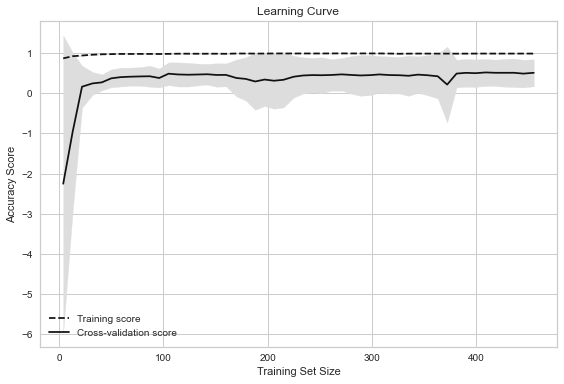

In [102]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestRegressor(),
                                                        X_hous, Y_hous, cv=10,
                                                        scoring='r2',
                                                        n_jobs=-1,
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111", label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                 color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

[<ins>Using Yellowbrick</ins>](https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html#)

In [103]:
from yellowbrick.model_selection import LearningCurve

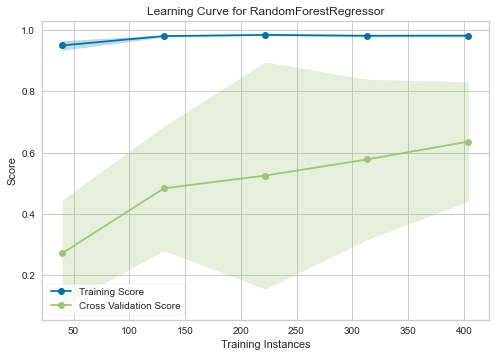

<AxesSubplot:title={'center':'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [104]:
visualizer = LearningCurve(RandomForestRegressor(), scoring='r2')

visualizer.fit(X_hous, Y_hous)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

<a id="vcurve"></a>
<h3 style="text-decoration:underline">Visualizing the Effect of Hyperparameter
Values (Validation curve)</h3>

Most training algorithms contain hyperparameters that must be chosen before the training process begins. For example, a random forest classifier creates a "forest" of decision trees, each of which votes on the predicted class of an observation. One hyperparameter in random forest classifiers is the number of trees in the forest. Most often hyperparameter values are selected during model selection. However, it is occasionally useful to visualize how model performance changes as the hyperparameter value changes. 

In the following example, we plot the changes in accuracy for a random forest classifier for the training set and during cross-validation as the number of trees increases. When we have a small number of trees, both the training and cross-validation score are low, suggesting the model is underfitted. As the number of trees increases to 250, the accuracy of both levels off, suggesting there is probably not much value in the computational cost of training a massive forest.

[<ins>Using Sklearn</ins>](https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html#)

In [105]:
from sklearn.model_selection import validation_curve

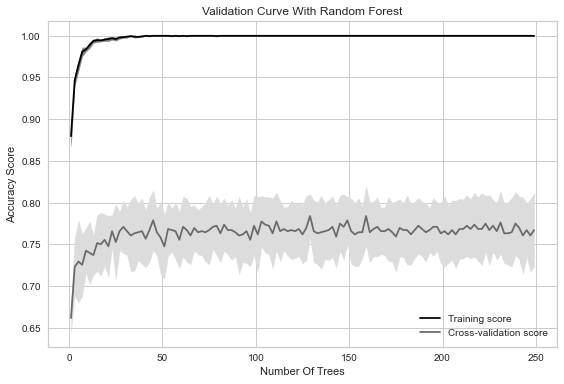

In [106]:
# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), X_diab,
                                             Y_diab,
                                             param_name="n_estimators",
                                             param_range=np.arange(1, 250, 2),
                                             cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(np.arange(1, 250, 2), train_mean, label="Training score", color="black")
plt.plot(np.arange(1, 250, 2), test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(np.arange(1, 250, 2), train_mean - train_std, 
                 train_mean + train_std, color="gray")
plt.fill_between(np.arange(1, 250, 2), test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

[<ins>Using Yellowbrick</ins>](https://www.scikit-yb.org/en/latest/api/model_selection/validation_curve.html)

Random trees become more overfit the deeper they are because at each level of the tree the partitions are dealing with a smaller subset of data. One way to deal with this overfitting process is to limit the depth of the tree. The validation curve explores the relationship of the `max_depth` parameter to the $R^2$ score with 10 shuffle split cross-validation. The `param_range` argument specifies the values of max_depth, here from 1 to 10 inclusive.

In [107]:
from yellowbrick.model_selection import ValidationCurve

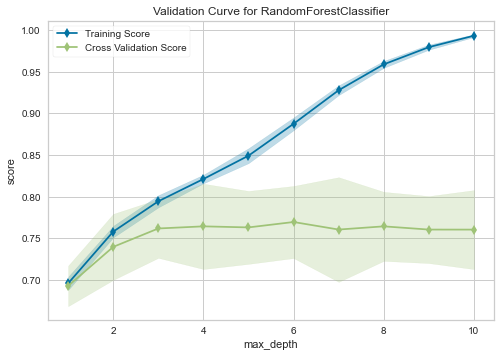

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [108]:
viz = ValidationCurve(RandomForestClassifier(), param_name="max_depth",
                      param_range=np.arange(1, 11), cv=10, scoring="accuracy")

# Fit and show the visualizer
viz.fit(X_diab, Y_diab)
viz.show()

The k nearest neighbors (kNN) model is commonly used when similarity is important to the interpretation of the model. Choosing k is difficult, the higher k is the more data is included in a classification, creating more complex decision topologies, whereas the lower k is, the simpler the model is and the less it may generalize. Using a validation curve seems like an excellent strategy for choosing k, and often it is. 

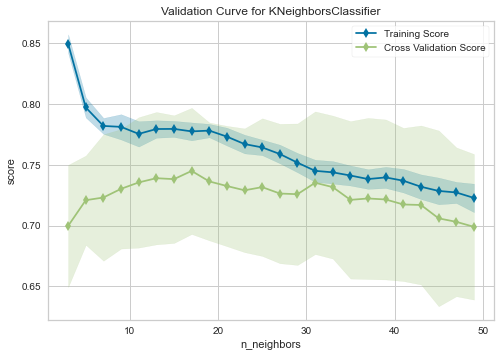

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='n_neighbors', ylabel='score'>

In [109]:
oz = ValidationCurve(KNeighborsClassifier(), param_name="n_neighbors",
    param_range=np.arange(3, 50, 2), cv=cv, scoring="f1_weighted", n_jobs=4)

# Using the same game dataset as in the SVC example
oz.fit(X_diab, Y_diab)
oz.show()

<a id="ml"></a>
<h2 align="center">SPOT-CHECK MACHINE LEARNING ALGORITHMS</h2>

Spot-checking is a way of discovering which algorithms perform well on our machine learning problem. We cannot know which algorithms are best suited to our problem beforehand. We must trial a number of methods and focus attention on those that prove themselves the most promising.

The question is not: *What algorithm should I use on my dataset?* Instead it is: *What algorithms should I spot-check on my dataset?* We can sometimes guess what algorithms might do well on the dataset, and this can be a good starting point. It is recommended trying a mixture of algorithms and see what is good at picking out the structure in the data.

Below are some suggestions when spot-checking algorithms on a dataset:
- Try a mixture of algorithm representations (e.g. instances and trees).
- Try a mixture of learning algorithms (e.g. different algorithms for learning the same type of representation).
- Try a mixture of modeling types (e.g. linear and nonlinear functions or parametric and nonparametric).

<a id="spot"></a>
<h3 style="text-decoration:underline">Classification Models</h3>

The following looks at six classification algorithms that can be used to spot-check a dataset. 
- **Linear machine learning algorithms** 
    - **Logistic Regression** - assumes a Gaussian distribution for the numeric input variables and can model binary classification problems.
    - **Linear Discriminant Anlysis** - a statistical technique for binary and multiclass classification. It too assumes a Gaussian distribution for the numerical input variables. 
    
    
- **Nonlinear machine learning algorithms**
    - **k-Nearest Neighbors** - The k-Nearest Neighbors algorithm (or KNN) uses a distance metric to find the k most similar instances in the training data for a new instance and takes the mean outcome of the neighbors as the prediction.
    - **Naive Bayes** - Naive Bayes calculates the probability of each class and the conditional probability of each class given each input value. These probabilities are estimated for new data and multiplied together, assuming that they are all independent (a simple or naive assumption). When working with real-valued data, a Gaussian distribution is assumed to easily estimate the probabilities for input variables using the Gaussian Probability Density Function.
    - **Classification and Regression Trees** - Classification and Regression Trees (CART or just decision trees) construct a binary tree from the training data. Split points are chosen greedily by evaluating each attribute and each value of each attribute in the training data in order to minimize a cost function (like the Gini index).
    - **Support Vector Machines** - Support Vector Machines (or SVM) seek a line that best separates two classes. Those data instances that are closest to the line that best separates the classes are called support vectors and influence where the line is placed. SVM has been extended to support multiple classes. Of particular importance is the use of different kernel functions via the kernel parameter.

In [110]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

Results for the LogisticRegression model: 0.776 +/- (0.052)
Results for the LinearDiscriminantAnalysis model: 0.773 +/- (0.052)
Results for the KNeighborsClassifier model: 0.727 +/- (0.062)
Results for the DecisionTreeClassifier model: 0.703 +/- (0.074)
Results for the GaussianNB model: 0.755 +/- (0.043)
Results for the SVC model: 0.760 +/- (0.053)


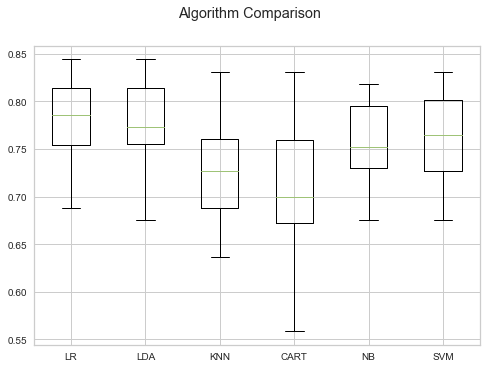

In [111]:
# prepare linear and non-linear models
models = [('LR', LogisticRegression(max_iter=300)),
          ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('NB', GaussianNB()),
          ('SVM', SVC())]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_diab, Y_diab, cv=kfold,
                                 scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"Results for the {str(model).split('(')[0]} model: {cv_results.mean():.3f} +/- ({cv_results.std():.3f})")

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<a id="check"></a>
<h3 style="text-decoration:underline">Regression Models</h3>

The following looks at seven regression algorithms that can be used to spot-check a dataset. 
- **Linear machine learning algorithms** 
    - **Linear Regression** - assumes a Gaussian distribution for the numeric input variables. It is also assumed that input variables are relevant to the output variable and that they are not highly correlated with each other
    - **Ridge Regression** - Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model measured as the sum squared value of the coefficient values (also called the L2-norm).
    - **LASSO Linear Regression** - The Least Absolute Shrinkage and Selection Operator (or LASSO for short) is a modification of linear regression, like ridge regression, where the loss function is modified to minimize the complexity of the model measured as the sum absolute value of the coefficient values (also called the L1-norm).
    - **Elastic Net Regression** - ElasticNet is a form of regularization regression that combines the properties of both Ridge Regression and LASSO regression. It seeks to minimize the complexity of the regression model (magnitude and number of regression coefficients) by penalizing the model using both the L2-norm (sum squared coefficient values) and the L1-norm (sum absolute coefficient values).

    
- **Nonlinear machine learning algorithms**
    - **k-Nearest Neighbors** - The k-Nearest Neighbors algorithm (or KNN) locates the k most similar instances in the training dataset for a new data instance. From the k neighbors, a mean or median output variable is taken as the prediction. Of note is the distance metric used (the `metric` argument). The Minkowski distance is used by default, which is a generalization of both the Euclidean distance (used when all inputs have the same scale) and Manhattan distance (for when the scales of the input variables differ).
    - **Classification and Regression Trees** - Classification and Regression Trees (CART or just decision trees) construct a binary tree from the training data. Split points are chosen greedily by evaluating each attribute and each value of each attribute in the training data in order to minimize a cost function (like the Gini index).
    - **Support Vector Machines** - Support Vector Machines (or SVM) seek a line that best separates two classes. Those data instances that are closest to the line that best separates the classes are called support vectors and influence where the line is placed. SVM has been extended to support multiple classes. Of particular importance is the use of different kernel functions via the kernel parameter.

In [112]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

Results for the LinearRegression model: -34.705 +/- (45.574)
Results for the Ridge model: -34.078 +/- (45.900)
Results for the Lasso model: -34.464 +/- (27.889)
Results for the ElasticNet model: -31.165 +/- (22.709)
Results for the KNeighborsRegressor model: -107.287 +/- (79.840)
Results for the DecisionTreeRegressor model: -36.180 +/- (24.224)
Results for the SVR model: -72.255 +/- (61.961)


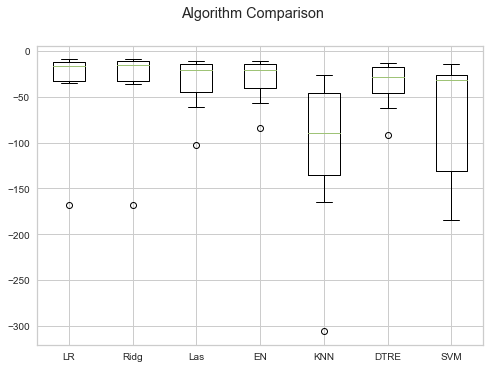

In [113]:
# prepare linear and non-linear models
models = [('LR', LinearRegression()),
          ('Ridg', Ridge()),
          ('Las', Lasso()),
          ('EN', ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('DTRE', DecisionTreeRegressor()),
          ('SVM', SVR())]

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_hous, Y_hous, cv=kfold,
                                 scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    print(f"Results for the {str(model).split('(')[0]} model: {cv_results.mean():.3f} +/- ({cv_results.std():.3f})")

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<a id="auto"></a>
<h2 align="center">AUTOMATE MACHINE LEARNING WORKFLOWS WITH PIPELINES</h2>

There are standard workflows in a machine learning project that can be automated. Standard because they overcome common problems like data leakage in your test harness. Pipelines help to clearly define and automate these workflows. Pipelines work by allowing for a linear sequence of data transforms to be chained together culminating in a modeling process that can be evaluated. The goal is to ensure that all of the steps in the pipeline are constrained to the data available for the evaluation, such as the training dataset or each fold of the cross validation procedure.

<a id="pipe"></a>
<h3 style="text-decoration:underline">Data Preparation and Modeling Pipeline</h3>

An easy trap to fall into in applied machine learning is leaking data from the training to the test dataset. To avoid this trap we need a robust test harness with strong separation of training and testing. This includes data preparation. Data preparation is one easy way to leak knowledge of the whole training dataset to the algorithm. For example, preparing data using normalization or standardization on the entire training dataset before learning would not be a valid test because the training dataset would have been influenced by the scale of the data in the test set. Pipelines help prevent data leakage in the test set by ensuring that data preparation like standardization is constrained to each fold of the cross-validation procedure.

In [114]:
# create pipeline
steps = [('standardize', StandardScaler()),
             ('lda', LinearDiscriminantAnalysis())]

model = Pipeline(steps=steps)

# evaluate pipeline
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_diab, Y_diab, cv=kfold)
print(results.mean())

0.773462064251538


**Note how the `Pipeline` itself is treated like an estimator and is evaluated in its entirety by the k-fold cross-validation procedure.**

<a id="extract"></a>
<h3 style="text-decoration:underline">Feature Extraction and Modeling Pipeline</h3>

Feature extraction is another procedure that is susceptible to data leakage. Like data preparation, feature extraction procedures must be restricted to the data in the training dataset. The pipeline provides a handy tool called `FeatureUnion` which allows the results of multiple feature selection and extraction procedures to be combined into a larger dataset on which a model can be trained. Importantly, all the feature extraction and the feature union occurs within each fold of the cross validation procedure.

In [115]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

In [116]:
# create feature union
features = [('pca', PCA(n_components=3)),
           ('select_best', SelectKBest(k=6))]
feature_union = FeatureUnion(features)

# create pipeline
steps = [('feature_union', feature_union),
             ('logistic', LogisticRegression(max_iter=300))]
model = Pipeline(steps)

# evaluate pipeline
kfold = KFold(n_splits=10)
results = cross_val_score(model, X_diab, Y_diab, cv=kfold)

print(results.mean())

0.7760423786739576


Note how the `FeatureUnion` is it’s own Pipeline that in turn is a single step in the final Pipeline used to feed Logistic Regression. This introduces the idea of embedding pipelines within pipelines.

<a id="ensemble"></a>
<h2 align="center">IMPROVE PERFORMANCE WITH ENSEMBLES</h2>

Ensembles have the potential to give a boost in accuracy on a dataset.

The three most popular methods for combining the predictions from different ensemble models are:
- **Bagging** - Building multiple models (typically of the same type) from different subsamples of the training dataset.
- **Boosting** - Building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the sequence of models.
- **Voting** - Building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions.

<a id="bag"></a>
<h3 style="text-decoration:underline">Bagging Algorithms</h3>

Bootstrap Aggregation (or Bagging) involves taking multiple samples from your training dataset (with replacement) and training a model for each sample. The final output prediction is averaged across the predictions of all of the sub-models. 
>**Bagging performs best with algorithms that have high variance.** 

<a id="bagtree"></a>
<h5 style="text-decoration:underline">Bagged Decision Trees</h5>

A popular example are **decision trees**, often constructed without pruning. 

In [117]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [118]:
kfold = KFold(n_splits=10)
model = DecisionTreeClassifier()

# create bagged classifier with a total of 100 trees
bagged_model = BaggingClassifier(base_estimator=model, n_estimators=100,
                                 random_state=7)
results = cross_val_score(bagged_model, X_diab, Y_diab, cv=kfold)

print(f"Results for bagged decision tree model: {results.mean():.3f} +/- ({results.std():.3f})")

Results for bagged decision tree model: 0.772 +/- (0.075)


<a id="forest"></a>
<h5 style="text-decoration:underline">Random Forest</h5>

**Random Forests** is an extension of bagged decision trees. Samples of the training dataset are taken with replacement, but the trees are constructed in a way that reduces the correlation between individual classifiers. Specifically, rather than greedily choosing the best split point in the construction of each tree, only a random subset of features are considered for each split.

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
kfold = KFold(n_splits=10)
model = RandomForestClassifier(n_estimators=100, max_features=3)

results = cross_val_score(model, X_diab, Y_diab, cv=kfold)

print(f"Results for random forest model: {results.mean():.3f} +/- ({results.std():.3f})")

Results for random forest model: 0.768 +/- (0.071)


<a id="extra"></a>
<h5 style="text-decoration:underline">Extra Trees</h5>

**Extra Trees** are another modification of bagging where random trees are constructed from samples of the training dataset.

In [121]:
from sklearn.ensemble import ExtraTreesClassifier

In [122]:
kfold = KFold(n_splits=10)
model = ExtraTreesClassifier(n_estimators=100, max_features=3)

results = cross_val_score(model, X_diab, Y_diab, cv=kfold)

print(f"Results for random forest model: {results.mean():.3f} +/- ({results.std():.3f})")

Results for random forest model: 0.760 +/- (0.070)


<a id="boost"></a>
<h3 style="text-decoration:underline">Boosting Algorithms</h3>

**Boosting ensemble algorithms** creates a sequence of models that attempt to correct the mistakes of the models before them in the sequence. Once created, the models make predictions which may be weighted by their demonstrated accuracy and the results are combined to create a final output prediction. 

<a id="ada"></a>
<h5 style="text-decoration:underline">AdaBoost</h5>

**AdaBoost** was perhaps the first successful boosting ensemble algorithm. It generally works by weighting instances in the dataset by how easy or difficult they are to classify, allowing the algorithm to pay less attention to them in the construction of subsequent models.

In [123]:
from sklearn.ensemble import AdaBoostClassifier

In [124]:
kfold = KFold(n_splits=10)
model = AdaBoostClassifier(n_estimators=30, random_state=7)

results = cross_val_score(model, X_diab, Y_diab, cv=kfold)

print(f"Results for ada boost model: {results.mean():.3f} +/- ({results.std():.3f})")

Results for ada boost model: 0.760 +/- (0.054)


<a id="gradient"></a>
<h5 style="text-decoration:underline">Stochastic Gradient Boosting</h5>

**Stochastic Gradient Boosting (or Gradient Boosting Machines)** are one of the most sophisticated ensemble techniques. It is also a technique that is proving to be perhaps one of the best techniques available for improving performance via ensembles.

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

In [126]:
kfold = KFold(n_splits=10)
model = GradientBoostingClassifier(n_estimators=100, random_state=7)

results = cross_val_score(model, X_diab, Y_diab, cv=kfold)

print(f"Results for gradient boost model: {results.mean():.3f} +/- ({results.std():.3f})")

Results for gradient boost model: 0.768 +/- (0.056)


<a id="vote"></a>
<h3 style="text-decoration:underline">Voting Ensemble</h3>

**Voting** is one of the simplest ways of combining the predictions from multiple machine learning algorithms. It works by first creating two or more standalone models from your training dataset. A Voting Classifier can then be used to wrap the models and average the predictions of the sub-models when asked to make predictions for new data. The predictions of the sub-models can be weighted, but specifying the weights for classifiers manually or even heuristically is difficult. More advanced methods can learn how to best weight the predictions from sub models, but this is called **stacking (stacked aggregation)** and is currently not provided in scikit-learn.

In [127]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [128]:
kfold = KFold(n_splits=10)

# create the sub models
estimators = [('logistic', LogisticRegression(max_iter=300)),
             ('cart', DecisionTreeClassifier()),
             ('svm', SVC())]

# create the ensemble model
ensemble = VotingClassifier(estimators)

results = cross_val_score(ensemble, X_diab, Y_diab, cv=kfold)

print(f"Results for voting model: {results.mean():.3f} +/- ({results.std():.3f})")

Results for voting model: 0.764 +/- (0.069)


<a id="tune"></a>
<h2 align="center">IMPROVE PERFORMANCE WITH ALGORITHM TUNING</h2>

In machine learning, we use training algorithms to learn the parameters of a model by minimizing some loss function. However, in addition many learning algorithms (e.g. support vector classifiers and random forests) also have hyperparameters that must be defined outside of the learning process. For example, random forests are collections of decision trees, however, the number of decision trees in the forest is not learned by the algorithm and must be set prior to fitting. This is often referred to as *hyperparameter tuning*, *hyperparameter optimization*, or *model selection*. Additionally, we often want to try multiple learning algorithms (e.g. trying both SVC and random forests to see which learning method produces the best model).

Machine learning models are parameterized so that their behavior can be tuned for a given problem. Models can have many parameters and finding the best combination of parameters can be treated as a search problem.
- Algorithm parameters are referred to as **hyperparameters**, whereas the coefficients found by the machine learning algorithm itself are referred to as **parameters**. 

Optimization suggests the search-nature of the problem. Phrased as a search problem, you can use different search strategies to find a good and robust parameter or set of parameters for an algorithm on a given problem.

<a id="grid"></a>
<h3 style="text-decoration:underline">Exhaustive Search: Grid Search Parameter Tuning</h3>

**`GridSearchCV`** is a brute-force approach to parameter tuning using crossvalidation. Specifically, a user defines sets of possible values for one or multiple hyperparameters, and then GridSearchCV will methodically build and evaluate a model for each combination of algorithm parameters specified in the grid. The model with the best performance score is selected as the best model.

In the following example, we use logistic regression as the learning algorithm, containing two hyperparameters: C and the regularization penalty. For each combination of C and regularization penalty values, we train the model and evaluate it using k-fold cross-validation. Thus, with 10 possible values of C, 2 possible values of regularization penalty, and 5 folds, we create $10 × 2 × 5 =100$ candidate models from which the best is selected.

In [129]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [130]:
# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(0, 4, 10)

param_grid = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=300, solver='liblinear')
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid.fit(X_diab, Y_diab)

print(grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.7721925133689839


In [131]:
# View best hyperparameters
print('Best Penalty:', grid.best_estimator_.get_params()['penalty'])
print('Best C:', grid.best_estimator_.get_params()['C'])

grid.best_estimator_

Best Penalty: l1
Best C: 21.544346900318832


LogisticRegression(C=21.544346900318832, max_iter=300, penalty='l1',
                   solver='liblinear')

In [132]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_penalty', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

By default, after identifying the best hyperparameters, GridSearchCV will retrain a model using the best hyperparameters on the entire dataset (rather than leaving a fold out for cross-validation). We can use this model to predict values like any other scikit-learn model.

In [133]:
grid.predict(X_diab)

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,

<a id="random"></a>
<h3 style="text-decoration:underline">Random Search Parameter Tuning</h3>

**Randomized search** is an approach to parameter tuning that will sample algorithm parameters from a random distribution (i.e. uniform) for a fixed number of iterations. A model is constructed and evaluated for each combination of parameters chosen.

In [134]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

A total of 100 iterations are performed with uniformly random alpha values selected in the range between 0 and 1 (the range that alpha values can take).

In [135]:
param_grid = {'alpha': uniform()}
model = Ridge()
rsearch = RandomizedSearchCV(estimator=model, 
                             param_distributions=param_grid,
                             n_iter=100, random_state=7, cv=5)
rsearch.fit(X_diab, Y_diab)
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

0.2761075573402853
0.9779895119966027


In [136]:
# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(0, 4, 10)

param_grid = dict(C=C, penalty=penalty)

model = LogisticRegression(max_iter=300, solver='liblinear')
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                             random_state=7, cv=5)
rsearch.fit(X_diab, Y_diab)

print(rsearch.best_score_)

0.7721925133689839


<a id="best"></a>
<h3 style="text-decoration:underline">Selecting Best Models from Multiple
Learning Algorithms</h3>

In [137]:
# Create a pipeline
pipe = Pipeline([("model", RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{"model": [LogisticRegression(max_iter=300, solver='liblinear')],
                 "model__penalty": ['l1', 'l2'],
                 "model__C": np.logspace(0, 4, 10)},
                {"model": [RandomForestClassifier()],
                 "model__n_estimators": [10, 100, 1000],
                 "model__max_features": [1, 2, 3]}]

# Create grid search
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=0)

# Fit grid search
best_model = gridsearch.fit(X_diab, Y_diab)

In [138]:
# View best model
best_model.best_estimator_.get_params()["model"]

RandomForestClassifier(max_features=3, n_estimators=1000)

<a id="best"></a>
<h3 style="text-decoration:underline">Selecting Best Models When Preprocessing</h3>

Very often we need to preprocess the data before using it to train a model. We have to be careful to properly handle preprocessing when conducting model selection. 

First, GridSearchCV uses cross-validation to determine which model has the highest performance. However, in cross-validation we are in effect pretending that the fold held out, as the test set is not seen, and thus not part of fitting any preprocessing steps (e.g., scaling or standardization). For this reason, we cannot preprocess the data and then run GridSearchCV. Rather, the preprocessing steps must be a part of the set of actions taken by GridSearchCV. While this might appear complex, the reality is that scikit-learn makes it simple. FeatureUnion allows us to combine multiple preprocessing actions properly. In the example below we use FeatureUnion to combine two preprocessing steps: standardize the feature values (StandardScaler) and Principal Component Analysis (PCA). This object is called preprocess and contains both of our preprocessing steps. We then include preprocess into a pipeline with the learning algorithm. The end result is that this allows us to outsource the proper (and confusing) handling of fitting, transforming, and training the models with combinations of hyperparameters to scikit-learn.

Second, some preprocessing methods have their own parameters, which often
have to be supplied by the user. For example, dimensionality reduction using
PCA requires the user to define the number of principal components to use to
produce the transformed feature set. Ideally, we would choose the number of
components that produces a model with the greatest performance for some
evaluation test metric. Luckily, scikit-learn makes this easy. When we include
candidate component values in the search space, they are treated like any other
hyperparameter to be searched over. 

In [139]:
# Create a preprocessing object that includes StandardScaler features and PCA
preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA())])

# Create a pipeline
pipe = Pipeline([("preprocess", preprocess),
                 ("classifier", LogisticRegression(max_iter=300,
                                                   solver='liblinear'))])

# Create space of candidate values
search_space = [{"preprocess__pca__n_components": [1, 2, 3],
                 "classifier__penalty": ["l1", "l2"],
                 "classifier__C": np.logspace(0, 4, 10)}]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=5, verbose=1, n_jobs=-1)

# Fit grid search
best_model = clf.fit(X_diab, Y_diab)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [140]:
best_model.best_estimator_

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('std', StandardScaler()),
                                                ('pca', PCA(n_components=2))])),
                ('classifier',
                 LogisticRegression(max_iter=300, penalty='l1',
                                    solver='liblinear'))])

In [141]:
best_model.best_estimator_.get_params()['classifier__C']

1.0

In [142]:
best_model.best_score_

0.7747899159663865

Nested cross-validation during model selection is a difficult concept for many people to grasp at first. Recall that in k-fold cross-validation, we train our model on k–1 folds of the data, use this model to make predictions on the remaining fold, and then evaluate our model best on how well our model’s predictions compare to the true values. We then repeat this process k times. In GridSearchCV and RandomizedSearchCV, we use cross-validation to evaluate which hyperparameter values produced the best models. However, a nuanced and generally underappreciated problem arises: since we used the data to select the best hyperparameter values, we cannot use that same data to evaluate the model’s performance. The solution? Wrap the cross-validation used for model search in another cross-validation. In nested cross-validation, the "inner" crossvalidation selects the best model, while the "outer" cross-validation provides us with an unbiased evaluation of the model’s performance. In the below example, the inner cross-validation is the `GridSearchCV` object, which we then wrap in an outer cross-validation using `cross_val_score`.

In [143]:
# Create a preprocessing object that includes StandardScaler features and PCA
preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA())])

# Create a pipeline
pipe = Pipeline([("preprocess", preprocess),
                 ("classifier", LogisticRegression(max_iter=300,
                                                   solver='liblinear'))])

# Create space of candidate values
search_space = [{"preprocess__pca__n_components": [1, 2, 3],
                 "classifier__penalty": ["l1", "l2"],
                 "classifier__C": np.logspace(0, 4, 10)}]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=5, verbose=1, n_jobs=-1)

# Conduct nested cross-validation and outut the average score
cross_val_score(clf, X_diab, Y_diab).mean()

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits


0.7721925133689839

<a id="save"></a>
<h2 align="center">SAVE AND LOAD MACHINE LEARNING MODELS</h2>

Finding an accurate machine learning model is not the end of the project. It is necessary to save a machine learning model so that it can be used to make predictions.

<a id="pickle"></a>
<h3><ins>Finalize Your Model with pickle</ins></h3>

**Pickle** is the standard way of serializing objects in Python. We can use the `pickle` operation to serialize our machine learning algorithms and save the serialized format to a file. Later we can load this file to deserialize our model and use it to make new predictions.

In [144]:
from pickle import dump, load

In [145]:
X_train, X_test, Y_train, Y_test = train_test_split(X_diab, Y_diab,
                                                    test_size=0.33,
                                                    random_state=7)

# Fit the model on the training set
model = LogisticRegression(max_iter=300)
model.fit(X_train, Y_train)

# save the model
filename = 'finalized_model_pickle.sav'
dump(model, open(filename, 'wb'))

# load the model
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.7874015748031497


<a id="joblib"></a>
<h3><ins>Finalize Your Model with Joblib</ins></h3>

The **`Joblib2`** library is part of the SciPy ecosystem and provides utilities for pipelining Python jobs. It provides utilities for saving and loading Python objects that make use of NumPy data structures, efficiently. This can be useful for some machine learning algorithms that require a lot of parameters or store the entire dataset (e.g. k-Nearest Neighbors).

In [146]:
import joblib

In [147]:
X_train, X_test, Y_train, Y_test = train_test_split(X_diab, Y_diab,
                                                    test_size=0.33,
                                                    random_state=7)
# Fit the model on the training set
model = LogisticRegression(max_iter=300)
model.fit(X_train, Y_train)

# save the model
filename = 'finalized_model_joblib.sav'
dump(model, open(filename, 'wb'))

# load the model
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.7874015748031497


<a id="ref"></a>
<h2><mark style="background-color: yellow">REFERENCES</mark></h2>

<ins>BOOKS</ins>
- [Machine Learning Algorithms From Scratch by Jason Brownlee](https://machinelearningmastery.com/machine-learning-algorithms-from-scratch/)
- [Machine Learning Mastery With Python by Jason Brownlee](https://machinelearningmastery.com/machine-learning-with-python/)
- [Data Preparation for Machine Learning by Jason Brownlee](https://machinelearningmastery.com/data-preparation-for-machine-learning/)
- [Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning](https://gaurav320.github.io/vpspu.github.io/eb/pdf/ML.pdf)

<ins>ARTICLES / WEBSITES</ins>
- [Towards Data Science - Choosing a Baseline Accuracy for a Classification Model](https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f)
- [Why every statistician should know about cross-validation - by Rob J Hyndman](https://robjhyndman.com/hyndsight/crossvalidation/)
- [ROC Curves in Python and R](https://community.alteryx.com/t5/Data-Science/ROC-Curves-in-Python-and-R/ba-p/138430)
- [Wikipedia - Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
- [Tutorial: Learning Curves for Machine Learning in Python](https://www.dataquest.io/blog/learning-curves-machine-learning/)

<ins>PYTHON PACKAGES</ins>
- [Scikit Learn - Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
- [Scikit Learn - Dummy (baseline) Estimators](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)
- [Yellowbrick - Classification Visualizers](https://www.scikit-yb.org/en/latest/api/classifier/index.html)
- [Scikit-Learn - Precision-Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#)
- [Scikit-Learn - Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#)
- [Scikit-Learn - Gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#)